In [1]:

# Access modules in the py folder
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# Get needed libraries
from FRVRS import fu, nu
import numpy as np
import os
import os.path as osp
from pandas import DataFrame, Series, concat, notnull
import pandas as pd
import re

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(
    metrics_evaluation_open_world_df='', metrics_evaluation_open_world_file_stats_df='', metrics_evaluation_open_world_scene_stats_df=''
)
logs_df = data_frames_list['metrics_evaluation_open_world_df']
file_stats_df = data_frames_list['metrics_evaluation_open_world_file_stats_df']
scene_stats_df = data_frames_list['metrics_evaluation_open_world_scene_stats_df']

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_scene_stats_df.pkl.



# Dataset Built for Metrics Evaluation Open World


Conduct some exploratory analysis of the open world segments for the ITM scenarios from the Metrics Evaluation.
For context, results of these analyses is a goal for the 4/30 results meeting (stretch) or the PI meeting (more likely).

<h2>Which factors contribute to the variance in these outcomes?</h2>
Conceptually, I want an exploratory factor analysis using these IVs and DVs. But I suspect we don’t have enough data for that so as close as we can get to that, let’s get creative.
My thought was to keep the environments separate because each participant did 2 of the environments so if we use 1 to explore, we can use the other to confirm. But again, I recognize we do not have power to do these properly.

In [4]:

# Add file and scene columns to the 11-patient scenes
participant_columns = [
    'ST_Del_Text', 'AD_AttribGrp_Sim', 'Trust', 'ST_ConfFC_Text', 'Delegation', 'YrsMilExp', 'AD_Del_Text', 'MedExp', 'AD_AttribGrp_Text',
    'ST_ConfFC_Omni_Text', 'PropTrust', 'ST_KDMA_Text', 'AD_KDMA_Text', 'ST_AttribGrp_Text', 'ST_Del_Omni_Text', 'MilitaryExp', 'AD_ConfFC_Omni_Text',
    'MedRole', 'ST_AttribGrp_Sim', 'AD_ConfFC_Text', 'ST_KDMA_Sim', 'AD_Del_Omni_Text', 'AD_KDMA_Sim'
]
needed_columns = [
    'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'configData_scene',
    'configData_scenarioData_name', 'configData_scenarioData_description', 'encounter_layout', 'participantId', 'ParticipantID', 'Sim1', 'Sim2'
] + participant_columns
elevens_df = fu.get_elevens_data_frame(
    logs_df, file_stats_df, scene_stats_df, needed_columns=needed_columns
)
print(elevens_df.shape) # (80364, 142)

(85851, 142)



## There should be a total of 23 participants labeled 2024201 to 2024223

In [6]:

# Create a table of the count of JSON files that have the participant ID suffixed to their file name
from IPython.display import HTML

logs_path = '../data/logs/Metrics Evaluation Open World'
rows_list = []
for participant_id in range(2_024_201, 2_024_223+1):
    mask_series1 = (file_stats_df.ParticipantID == participant_id)
    mask_series2 = file_stats_df.participantId.map(lambda x: str(x) == str(participant_id))
    print(
        participant_id,
        file_stats_df[mask_series1].shape[0],
        file_stats_df[mask_series2].shape[0]
    )
    row_dict = {'participant_id': participant_id}
    file_count = 0
    for sub_directory, directories_list, files_list in os.walk(logs_path):
        for file_name in files_list:
            if file_name.endswith('.json') and ('_' in file_name):
                if (file_name.split('_')[1].split('.')[0] == str(participant_id)):
                    file_count += 1
    row_dict['file_count'] = file_count
    # print(participant_id, file_count, 'files with the participant ID in the file name')
    rows_list.append(row_dict)
print()
caption_regex = re.compile(r'<table([^>]*)>(\s*)')
regex_str = r'<table\1>\2<caption>This is the new table of the count of JSON files that have the participant ID suffixed to their file name:</caption>\2'
html_str = caption_regex.sub(regex_str, DataFrame(rows_list).to_html(), 1)
html_str = re.sub(r'\s+<th>\d*</th>', '', html_str)
HTML(html_str)

2024201 2 2
2024202 2 2
2024203 2 2
2024204 2 2
2024205 2 1
2024206 2 2
2024207 2 2
2024208 2 2
2024209 2 1
2024210 0 0
2024211 2 2
2024212 2 2
2024213 2 0
2024214 2 1
2024215 1 2
2024216 2 2
2024217 2 2
2024218 2 2
2024219 2 2
2024220 2 2
2024221 2 2
2024222 2 2
2024223 2 2



participant_id,file_count
2024201,2
2024202,2
2024203,2
2024204,2
2024205,2
2024206,2
2024207,2
2024208,2
2024209,2
2024210,0


In [9]:

# Check out the various sub directories associated with participant JSON files
rows_list = []
for participant_id in range(2_024_201, 2_024_223+1):
    for sub_directory, directories_list, files_list in os.walk(logs_path):
        for file_name in files_list:
            if file_name.endswith('.json') and ('_' in file_name):
                if (file_name.split('_')[1].split('.')[0] == str(participant_id)):
                    directory_suffix = sub_directory.replace('../data/logs/Metrics Evaluation Open World/', '')
                    folder_names_list = re.split('/', directory_suffix, 0)
                    row_dict = {'participant_id': participant_id}
                    for i, folder_name in enumerate(folder_names_list): row_dict[f'folder{i}'] = folder_name
                    rows_list.append(row_dict)
df = DataFrame(rows_list)
folders_df = DataFrame([])
groupby_columns = ['participant_id', 'folder0']
for (participant_id, folder0), folder0_df in df.groupby(groupby_columns):
    folders_df = pd.concat([folders_df, folder0_df], axis='index').reset_index(drop=True)
folders_df.sort_values(['participant_id'] + [f'folder{i}' for i in range(len(folders_df.columns)-1)])

,participant_id,folder0
0,2024201,23081f6e-875e-44f5-8bd0-edc3905f5c2c_2024201
1,2024201,bccb0095-5efd-4c5c-ad58-8b8624f9ab56_2024201
2,2024202,220b609b-0e35-454e-9afd-c84cbfa3e3ad_2024202
3,2024202,922ad146-241a-4ea6-8ff1-413d7e0d16ec_2024202
4,2024203,4bc46c8c-66e7-463d-b3a1-2a8303af4fd1_2024203
5,2024203,acf74a81-a534-44c7-9cb1-67ec381b5ee0_2024203
6,2024204,80f79d45-22fd-479d-b6e2-c62b5778e073_2024204
7,2024204,cbbf410f-4657-428e-9616-8a777cc4704d_2024204
8,2024205,ddfb4e6e-f7c3-4321-89df-b6208f336318_2024205
9,2024205,df2fcf88-874b-4cf9-9707-3fa0b30c348f_2024205



## Create Tag Dataframes

In [10]:

# Iterate through each patient of each scene of each session of the 11-patient data frame
rows_list = []
for encounter_layout, responder_categories_df in elevens_df.groupby('encounter_layout'):
    for (session_uuid, scene_id, patient_id), patient_df in responder_categories_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns):

        # Get non-null tag applied types and patient record SALTs
        mask_series = ~patient_df.tag_applied_type.isnull() | ~patient_df.patient_record_salt.isnull()
        if mask_series.any():
            tags_and_salts_df = patient_df[mask_series]

            # Add the groupby columns and an account of the patient's existence to the row dictionary
            row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
            row_dict['encounter_layout'] = encounter_layout
            for cn in participant_columns:
                cv = patient_df[cn].mode().squeeze()
                if not isinstance(cv, pd.Series): row_dict[cn] = cv
            row_dict['patient_count'] = 1

            # Add the TAG_APPLIED tag value for this patient
            last_tag = fu.get_last_tag(tags_and_salts_df)
            row_dict['last_tag'] = last_tag

            # Add the PATIENT_RECORD SALT value for this patient
            max_salt = fu.get_max_salt(patient_df=tags_and_salts_df)
            row_dict['max_salt'] = max_salt

            # Add the predicted tag value for this patient based on the SALT value
            try: predicted_tag = fu.salt_to_tag_dict.get(max_salt, np.nan)
            except Exception: predicted_tag = np.nan
            row_dict['predicted_tag'] = predicted_tag

            # Add if the tagging was correct for this patient, then the row to the list
            row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)
            rows_list.append(row_dict)

# Create the tag-to-SALT data frame
tag_to_salt_df = pd.DataFrame(rows_list)

# Convert the tagged, SALT, and predicted tag columns to their custom categorical types
tag_to_salt_df.last_tag = tag_to_salt_df.last_tag.astype(fu.colors_category_order)
tag_to_salt_df.max_salt = tag_to_salt_df.max_salt.astype(fu.salt_category_order)
tag_to_salt_df.predicted_tag = tag_to_salt_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical orders
tag_to_salt_df = tag_to_salt_df.sort_values('predicted_tag')

In [11]:

# Get the total and correct counts for each run for each tag
rows_list = []

# Add the normal section
groupby_columns = ['session_uuid', 'scene_id', 'predicted_tag']
for encounter_layout, responder_categories_df in tag_to_salt_df.groupby('encounter_layout'):
    for (session_uuid, scene_id, predicted_tag), df in responder_categories_df.groupby(groupby_columns):
        
        # Add the groupby columns to the row dictionary
        row_dict = {cn: eval(cn) for cn in groupby_columns}
        row_dict['encounter_layout'] = encounter_layout
        for cn in participant_columns:
            cv = df[cn].mean()
            if not isinstance(cv, pd.Series): row_dict['mean_' + cn] = cv

        # Add the total and correct counts for this run
        mask_series = (df.is_tag_correct == True)
        correct_count = df[mask_series].patient_count.sum()
        row_dict['correct_count'] = correct_count
        total_count = df.patient_count.sum()
        row_dict['total_count'] = total_count

        # Add percentage that tag is correct
        try: percentage_tag_correct = 100*correct_count/total_count
        except Exception: percentage_tag_correct = np.nan
        row_dict['percentage_tag_correct'] = percentage_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)

    # Add the not-tagged section
    for (session_uuid, scene_id), df in responder_categories_df.groupby(fu.scene_groupby_columns):

        # Add the groupby columns to the row dictionary
        row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
        row_dict['predicted_tag'] = 'Not Tagged'
        row_dict['encounter_layout'] = encounter_layout
        for cn in participant_columns:
            cv = df[cn].mean()
            if not isinstance(cv, pd.Series): row_dict['mean_' + cn] = cv

        # Add the total and correct counts for this run
        mask_series = (df.is_tag_correct == True)
        correct_count = df[mask_series].patient_count.sum()
        row_dict['correct_count'] = correct_count
        total_count = df.patient_count.sum()
        row_dict['total_count'] = total_count

        # Add percentage that tag is correct
        try: percentage_tag_correct = 100*correct_count/total_count
        except Exception: percentage_tag_correct = np.nan
        row_dict['percentage_tag_correct'] = percentage_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)
correct_count_by_tag_df.predicted_tag = correct_count_by_tag_df.predicted_tag.astype(fu.colors_category_order)


<h2>We only want to use data from the following characters within each csv (by environment):</h2>
<h3>Desert:</h3>
<ul>
    <li>Open World Marine 1 Female</li>
    <li>Open World Marine 2 Male</li>
    <li>Open World Civilian 1 Male</li>
    <li>Open World Civilian 2 Female</li>
</ul>
<h3>Jungle:</h3>
<ul>
    <li>Open World Marine 1 Male</li>
    <li>Open World Marine 2 Female</li>
    <li>Open World Marine 3 Male</li>
    <li>Open World Marine 4 Male</li>
</ul>
<h3>Submarine:</h3>
<ul>
    <li>Navy Soldier 1 Male</li>
    <li>Navy Soldier 2 Male</li>
    <li>Navy Soldier 3 Male</li>
    <li>Navy Soldier 4 Female</li>
</ul>
<h3>Urban:</h3>
<ul>
    <li>Marine 1 Male</li>
    <li>Marine 2 Male</li>
    <li>Marine 3 Male</li>
    <li>Marine 4 Male</li>
    <li>Civilian 1 Female</li>
</ul>

In [12]:

# Get all patient stats
from numpy import nan

rows_list = []
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    scene_start = fu.get_scene_start(scene_df)
    for (encounter_layout, patient_id), patient_df in scene_df.groupby(['encounter_layout', 'patient_id']):
        row_dict = {cn: eval(cn) for cn in ['encounter_layout'] + fu.patient_groupby_columns}
        for cn in participant_columns:
            cv = patient_df[cn].mode().squeeze()
            if not isinstance(cv, pd.Series): row_dict[cn] = cv
        
        row_dict['correct_bleeding_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(patient_df)
        row_dict['first_patient_interaction'] = fu.get_first_patient_triage(patient_df)
        row_dict['last_patient_interaction'] = fu.get_last_patient_interaction(patient_df)
        row_dict['last_tag'] = fu.get_last_tag(patient_df)
        row_dict['life_threatened'] = fu.get_is_life_threatened(patient_df)
        row_dict['max_salt'] = fu.get_max_salt(patient_df)
        row_dict['maximum_injury_severity'] = fu.get_maximum_injury_severity(patient_df)
        row_dict['patient_dead'] = fu.get_is_patient_dead(patient_df)
        row_dict['patient_engagement_count'] = fu.get_patient_engagement_count(patient_df)
        row_dict['patient_gazed_at'] = fu.get_is_patient_gazed_at(patient_df)
        row_dict['patient_hemorrhaging'] = fu.get_is_patient_hemorrhaging(patient_df)
        row_dict['patient_severely_hemorrhaging'] = fu.get_is_patient_severely_hemorrhaging(patient_df)
        row_dict['patient_still'] = fu.get_is_patient_still(patient_df)
        row_dict['pulse_value'] = fu.get_pulse_value(patient_df)
        row_dict['tag_value'] = fu.get_tag_value(patient_df)
        row_dict['time_to_hemorrhage_control'] = fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start)
        
        mask_series = ~patient_df.tag_applied_type.isnull()
        tag_applied_type_count = patient_df[mask_series].tag_applied_type.unique().shape[0]
        mask_series = ~patient_df.patient_record_salt.isnull()
        patient_record_salt_count = patient_df[mask_series].patient_record_salt.unique().shape[0]
        if (tag_applied_type_count > 0) and (patient_record_salt_count > 0): row_dict['tag_correct'] = fu.get_is_tag_correct(patient_df)
        else: row_dict['tag_correct'] = nan
        
        mask_series = patient_df.action_type.isin(fu.action_types_list)
        row_dict['action_count'] = patient_df[mask_series].shape[0]
        
        mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['assessment_count'] = patient_df[mask_series].shape[0]
        
        mask_series = patient_df.action_type.isin(['INJURY_TREATED'])
        row_dict['treatment_count'] = patient_df[mask_series].shape[0]
        
        mask_series = patient_df.action_type.isin(['TAG_APPLIED'])
        row_dict['tag_application_count'] = patient_df[mask_series].shape[0]
        
        if (row_dict['max_salt'] == 'EXPECTANT'):
            mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
            row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
        else: row_dict['treated_expectant'] = nan
        
        rows_list.append(row_dict)
patient_stats_df = DataFrame(rows_list)
patient_stats_df.max_salt = patient_stats_df.max_salt.astype(fu.salt_category_order)
patient_stats_df.last_tag = patient_stats_df.last_tag.astype(fu.colors_category_order)
column_descriptions_df = nu.get_column_descriptions(patient_stats_df)
# mask_series = (df.min_value == False) & (df.max_value == True) & (df.dtype == 'object')
# for cn in df[mask_series].column_name: patient_stats_df[cn] = patient_stats_df[cn].astype(bool)
print(patient_stats_df.shape) # (415, 49)

(402, 49)


In [13]:

# Create a to-be-grouped summary of scene-based statistics
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
anova_rows_list = []
for encounter_layout, encounter_layout_df in patient_stats_df.groupby('encounter_layout'):
    patients_list = eval(f'{encounter_layout.lower()}_patients_list')
    for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
        mask_series = scene_df.patient_id.isin(patients_list)
        if mask_series.any():
            scene_start = fu.get_scene_start(scene_df)
            row_dict = {'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id}
            for cn in participant_columns:
                cv = patient_df[cn].mode().squeeze()
                if not isinstance(cv, pd.Series): row_dict[cn] = cv

            # Get the start of the whole scene
            scene_mask_series = True
            for cn in fu.scene_groupby_columns: scene_mask_series &= (elevens_df[cn] == eval(cn))
            scene_start = fu.get_scene_start(elevens_df[scene_mask_series])
            
            row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
            row_dict['total_action_count'] = scene_df.action_count.sum()
            row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
            row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
            row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
            row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max()

            mask_series = (scene_df.treated_expectant == 'yes')
            row_dict['treated_expectant_count'] = mask_series.sum()

            # Get the whole scene history
            scene_df = elevens_df[scene_mask_series]
            mask_series = scene_df.patient_id.isin(patients_list)
            
            row_dict['total_time_to_triage_scene'] = fu.get_triage_time(scene_df[mask_series])
            row_dict['time_to_hemorrhage_control'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
            
            # Duration of time from when the patient was first approached by the participant until
            # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
            row_dict['mean_time_for_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
            
            mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
            if mask_series.any():
                row_dict['mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
            
            anova_rows_list.append(row_dict)


<h2>Here is my initial list but I am open to suggestions and modifications</h2>
<h3>IVs (these are not available in the csv; we are working on calculating them now and can get you that info.)</h3>
<ul>
    <li>Participant medical role</li>
    <li>Years of experience</li>
    <li>ST alignment score (continuous or group assignment)</li>
    <li>AD alignment score (continuous or group assignment)</li>
</ul>
<h3>DVs</h3>
<ul>
    <li>Total number of actions</li>
    <li>Count of assessment actions</li>
    <li>Count of treatment actions</li>
    <li>Count of tags applied</li>
    <li>Order of patients engaged</li>
    <li>Tag color for each patient</li>
    <li>Treat expectant patient (yes/no)</li>
    <li>Triage efficiency</li>
    <li>Time to hemorrhage control</li>
</ul>

In [14]:

# Attempt to manufacture some better column names
from pandas import read_excel

file_path = '../data/xlsx/Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx'
dataset_organization_df = read_excel(file_path)

mask_series = ~dataset_organization_df.Description.isnull()#re.sub('[^A-Za-z0-9]+', '_', x)
df = dataset_organization_df[mask_series]
description_dict = df.set_index('Variable').Description.map(lambda x: ' (' + x + ')').to_dict()
new_description_dict = description_dict.copy()
for k, v in description_dict.items():
    new_description_dict[k] = v
    new_description_dict[f'{k}_Text'] = v
description_dict = new_description_dict.copy()

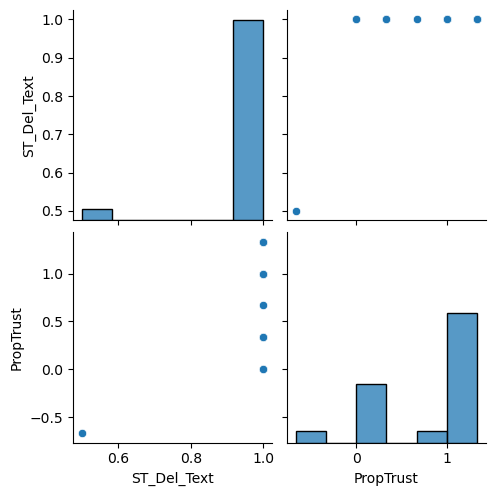

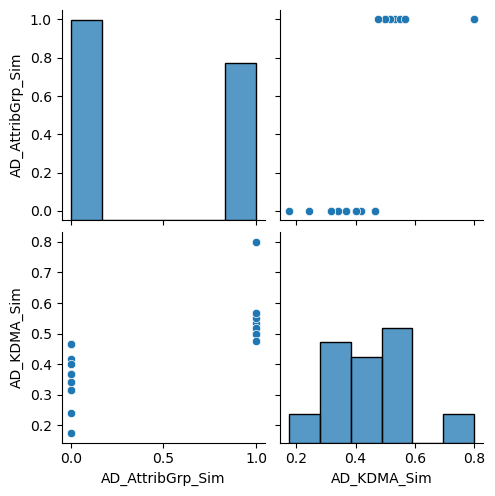

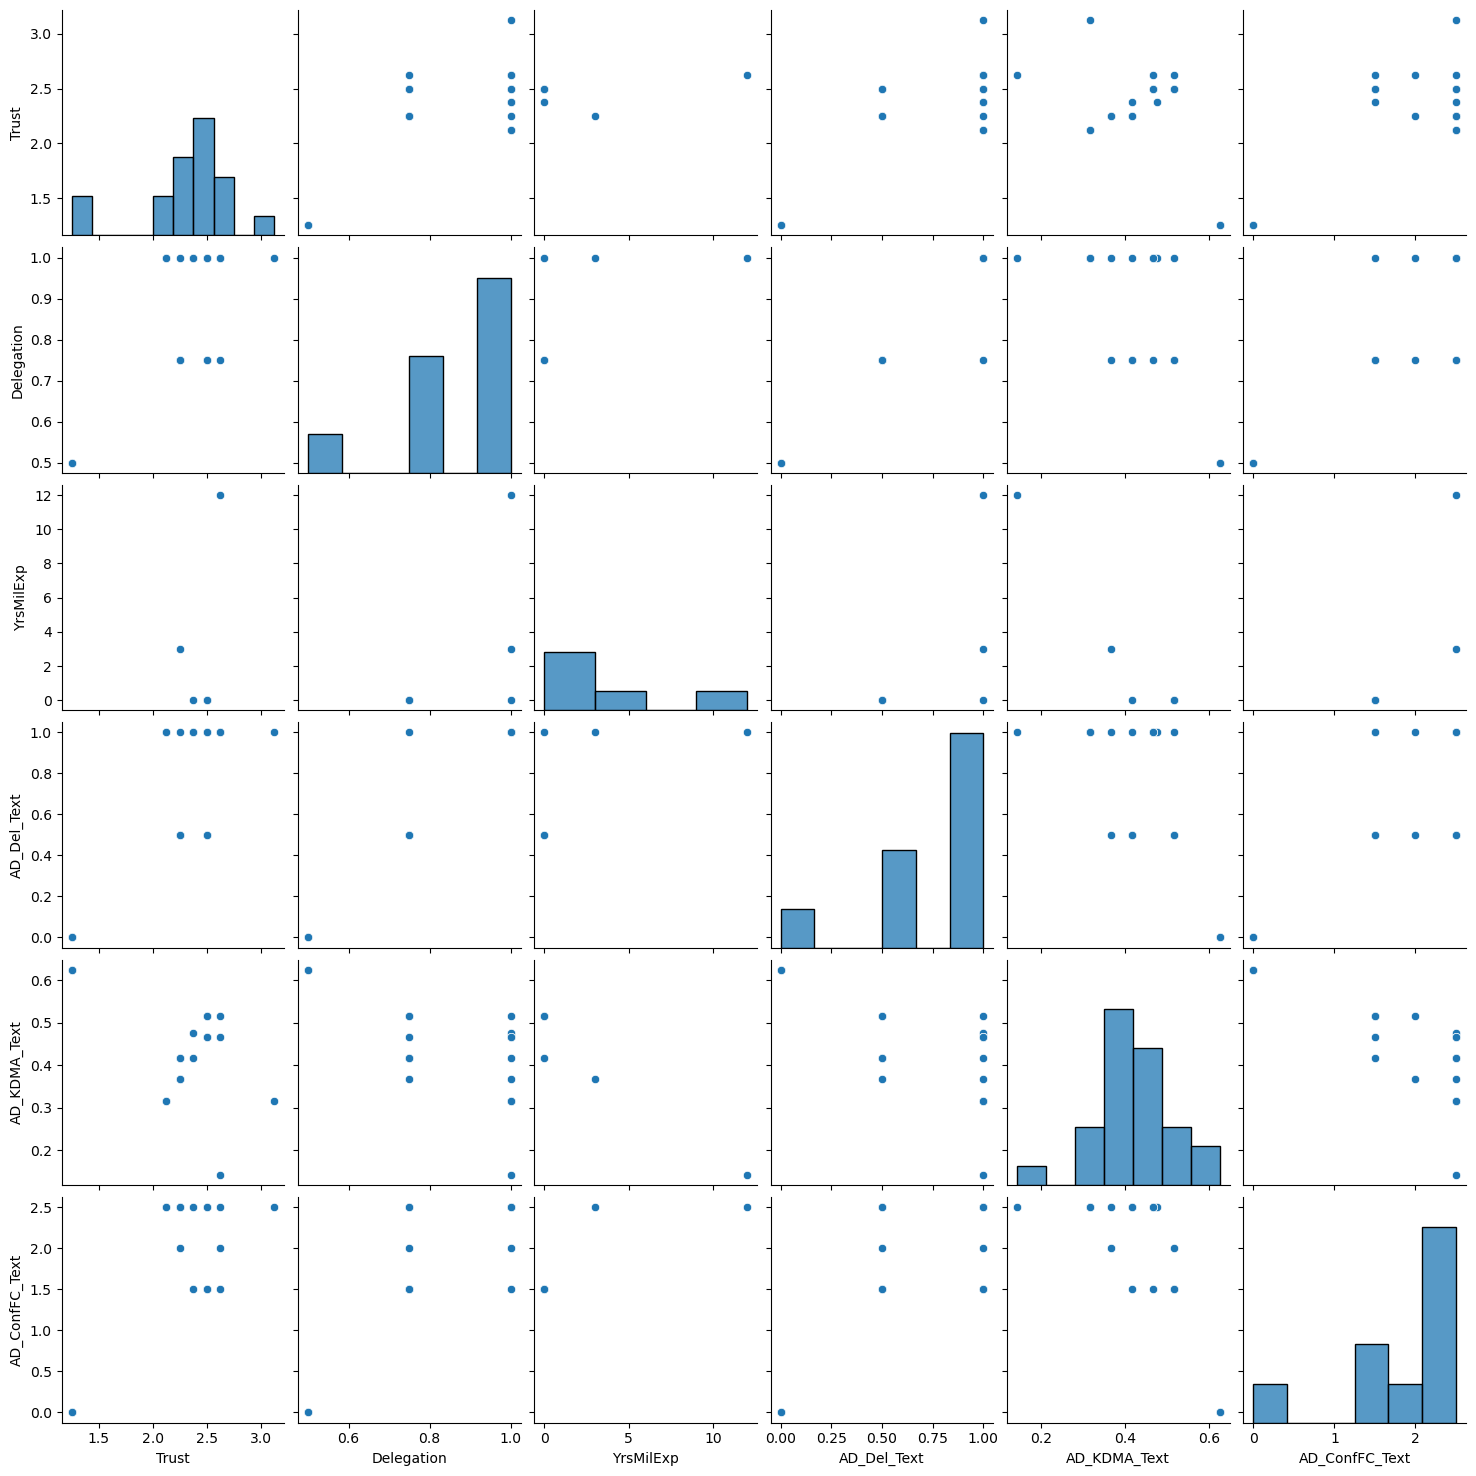

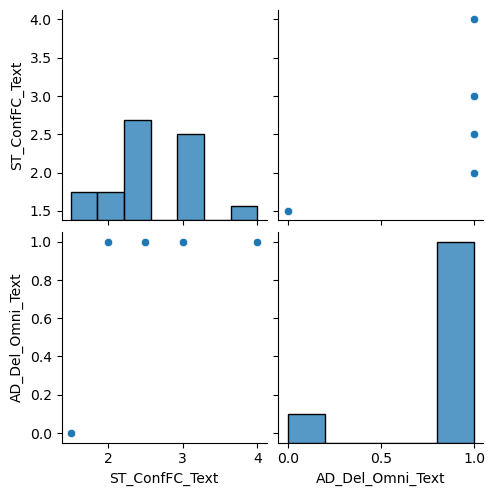

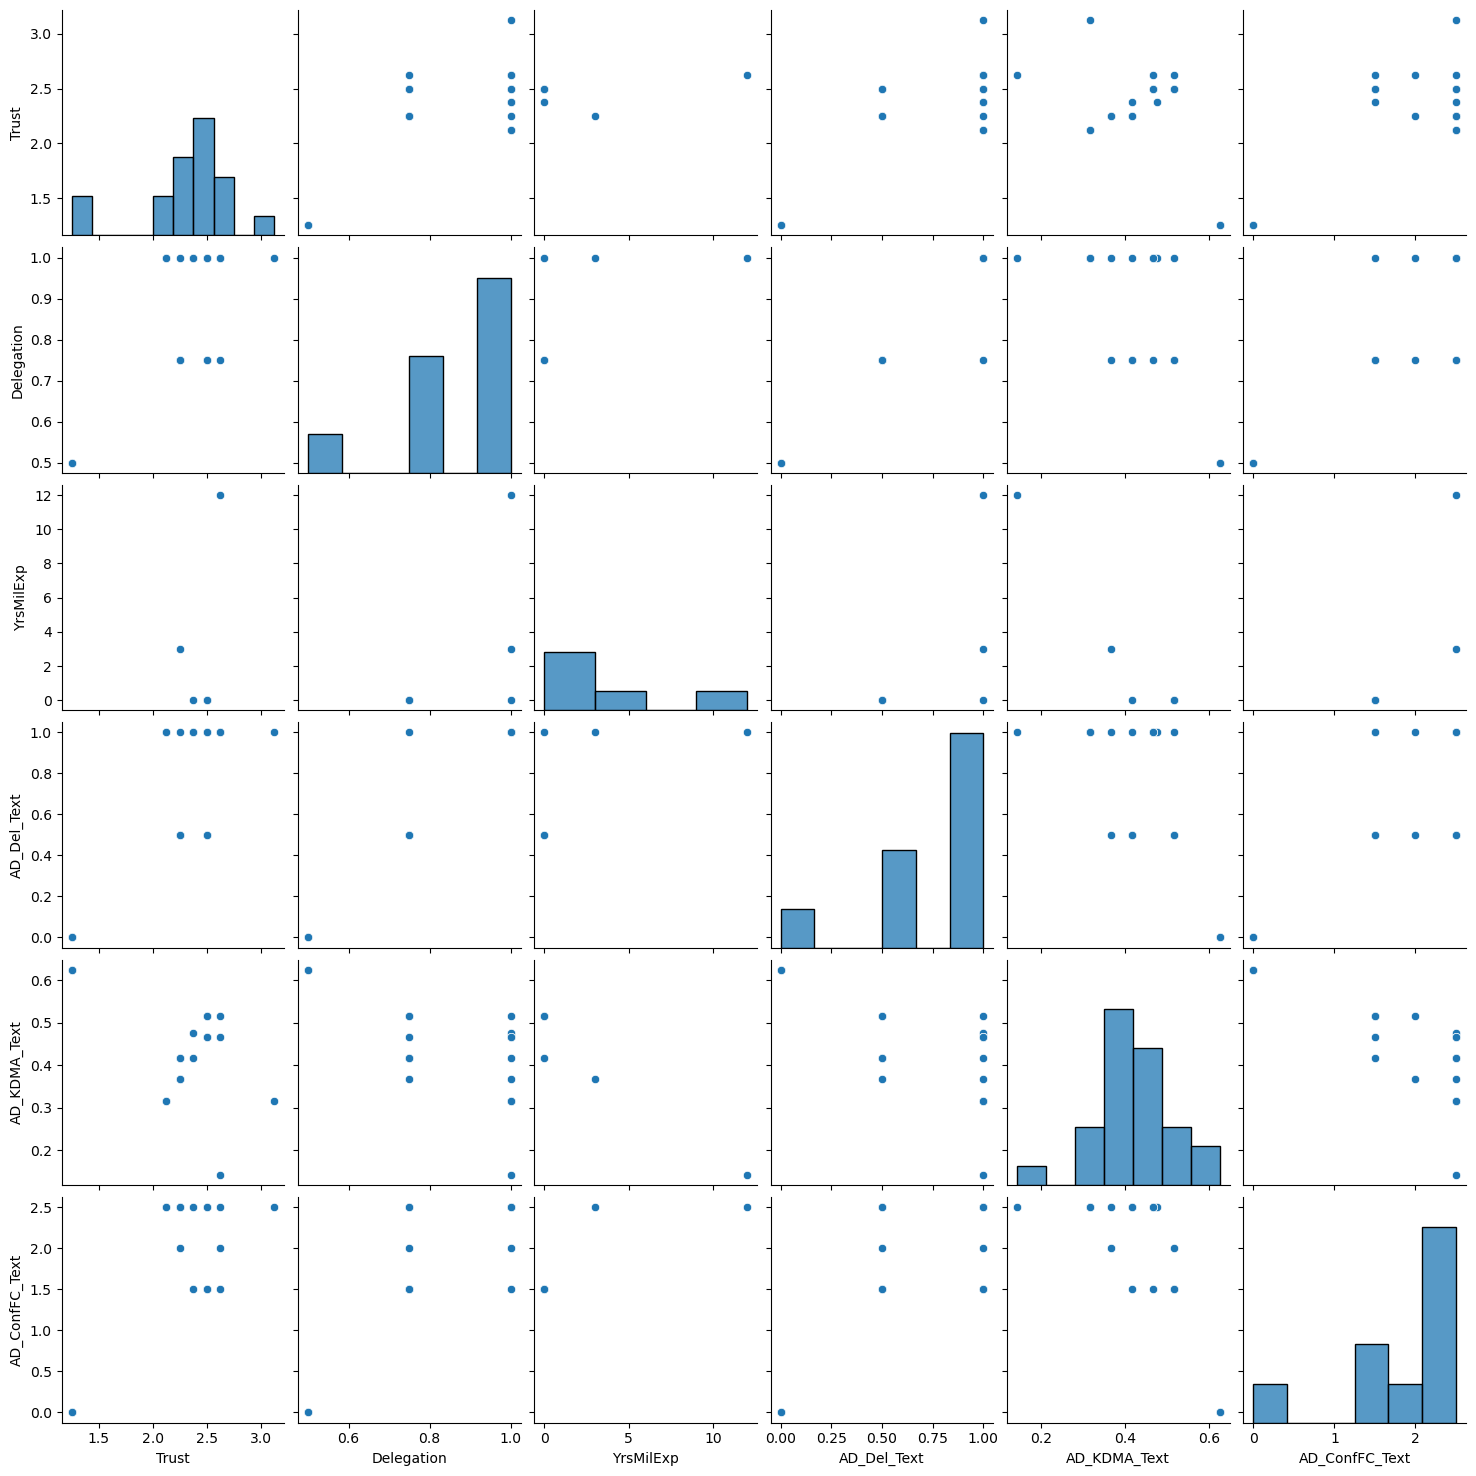

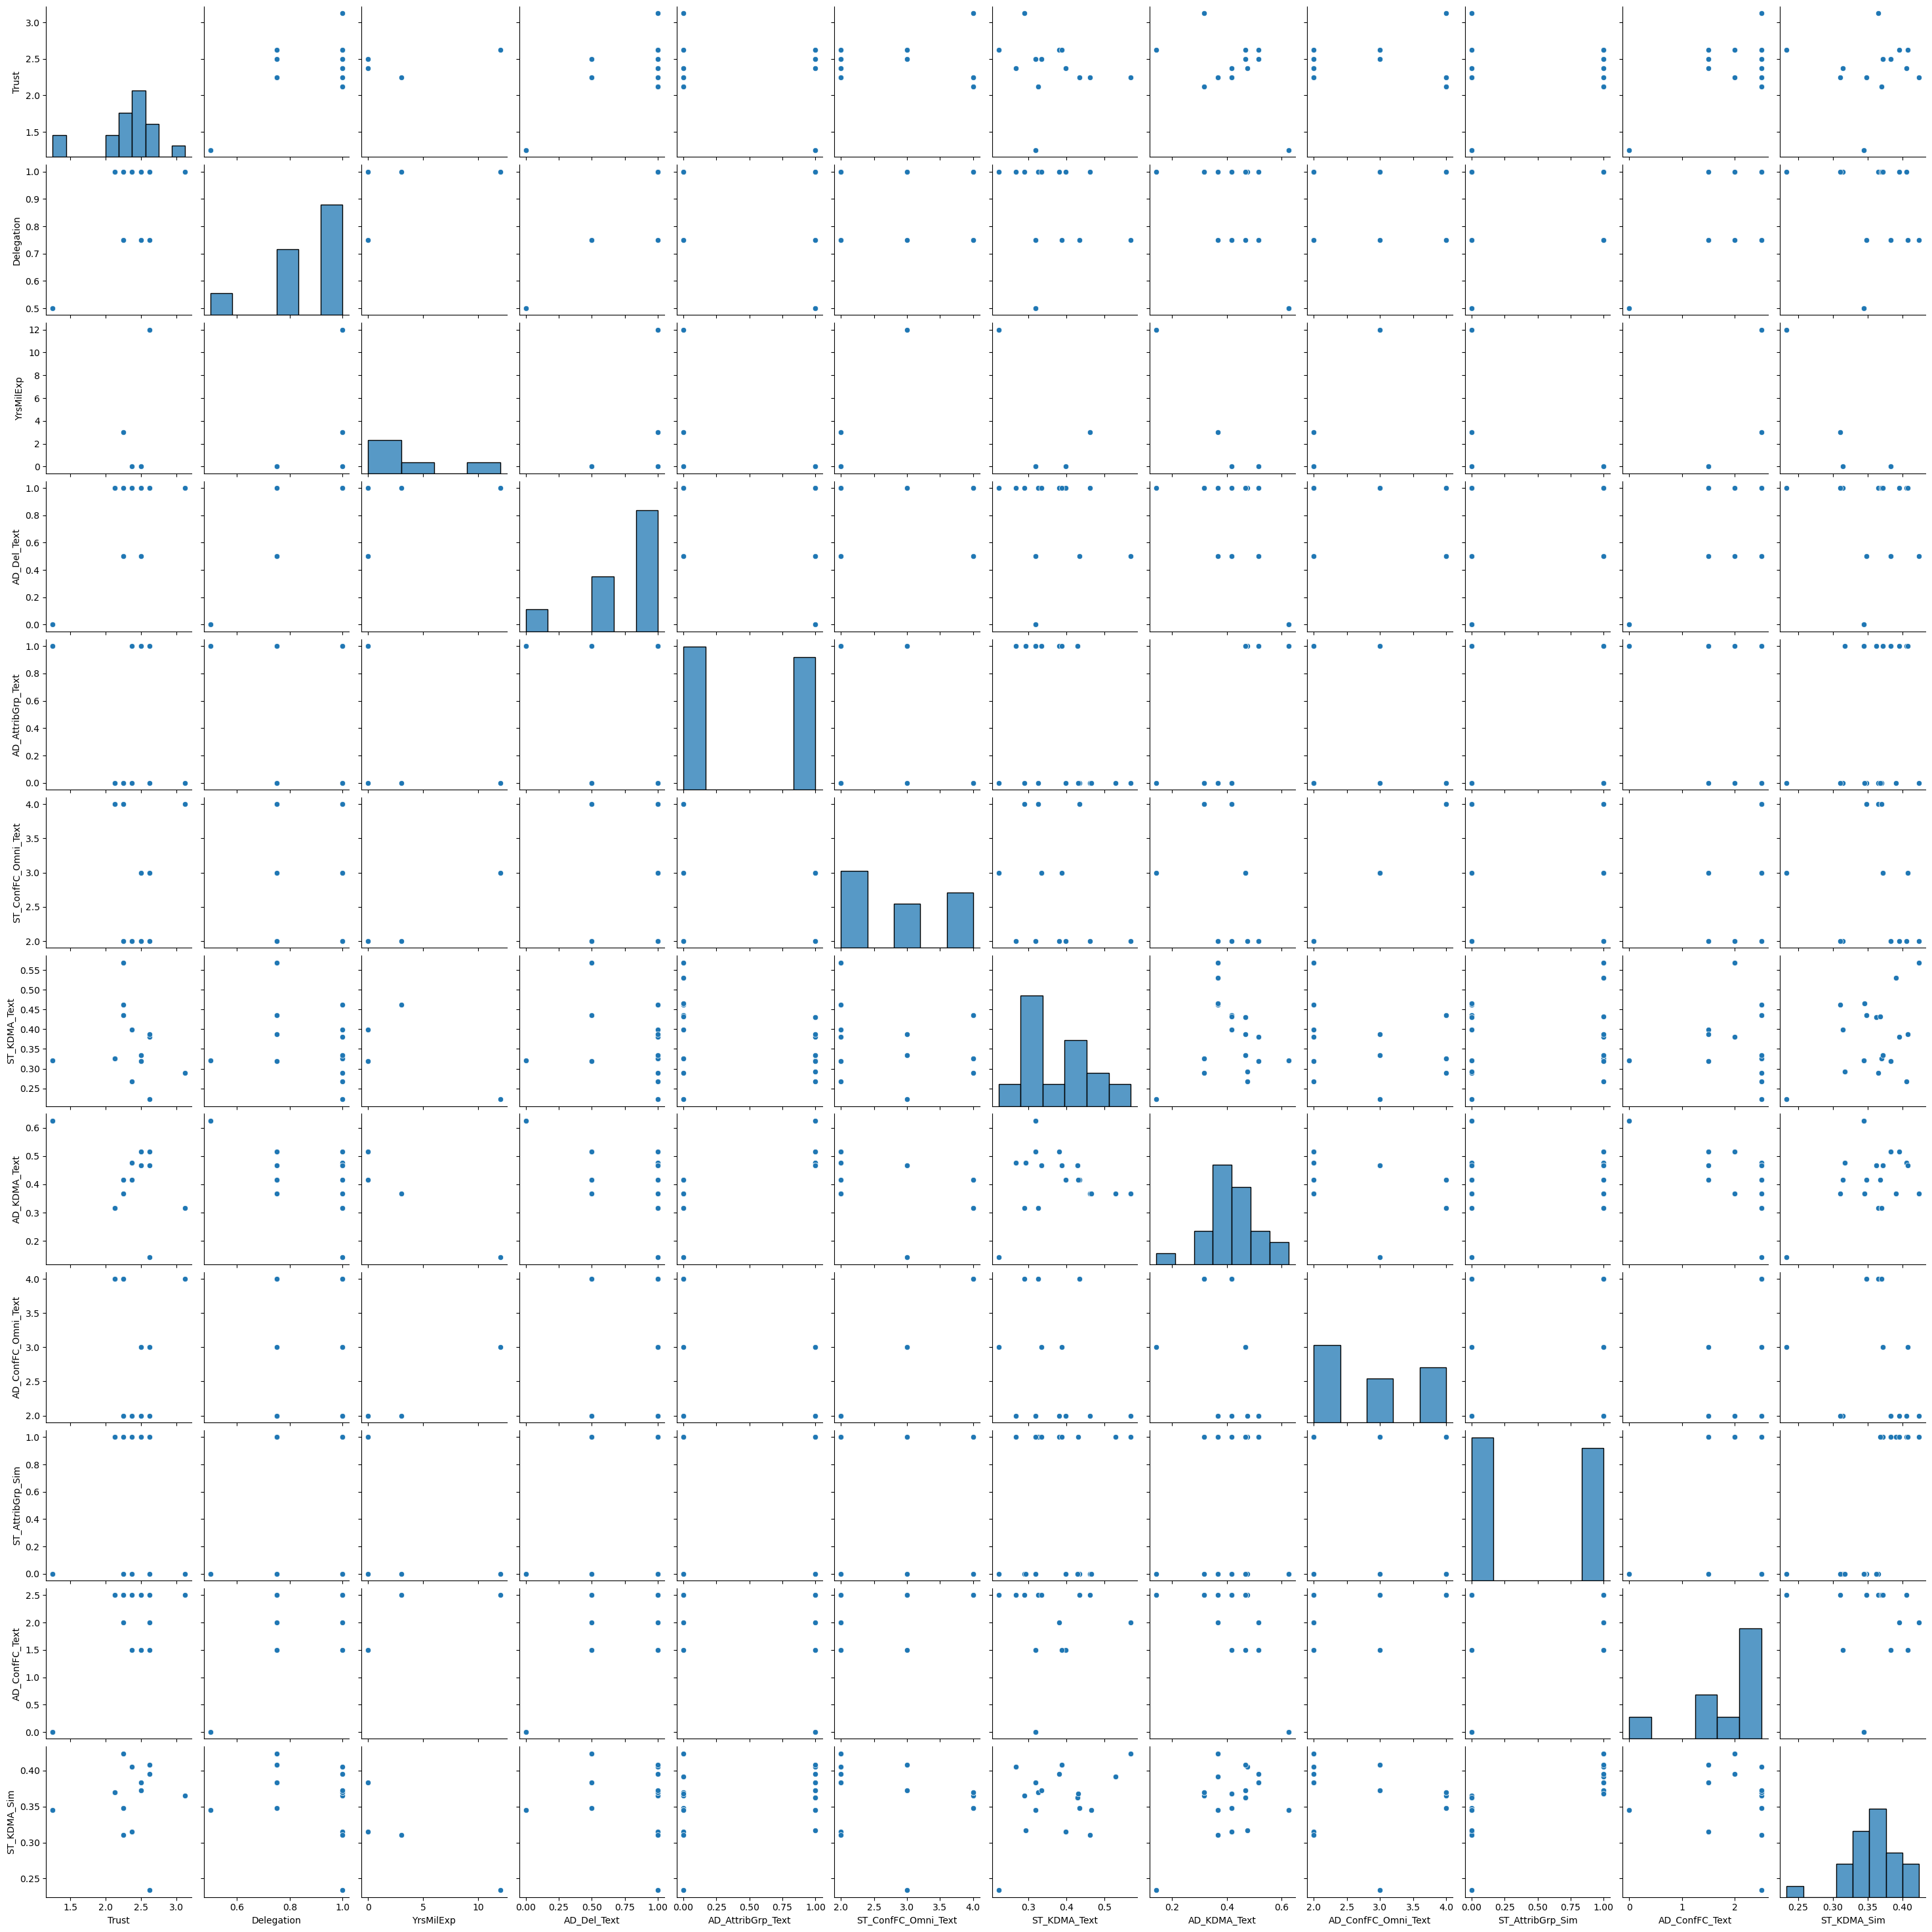

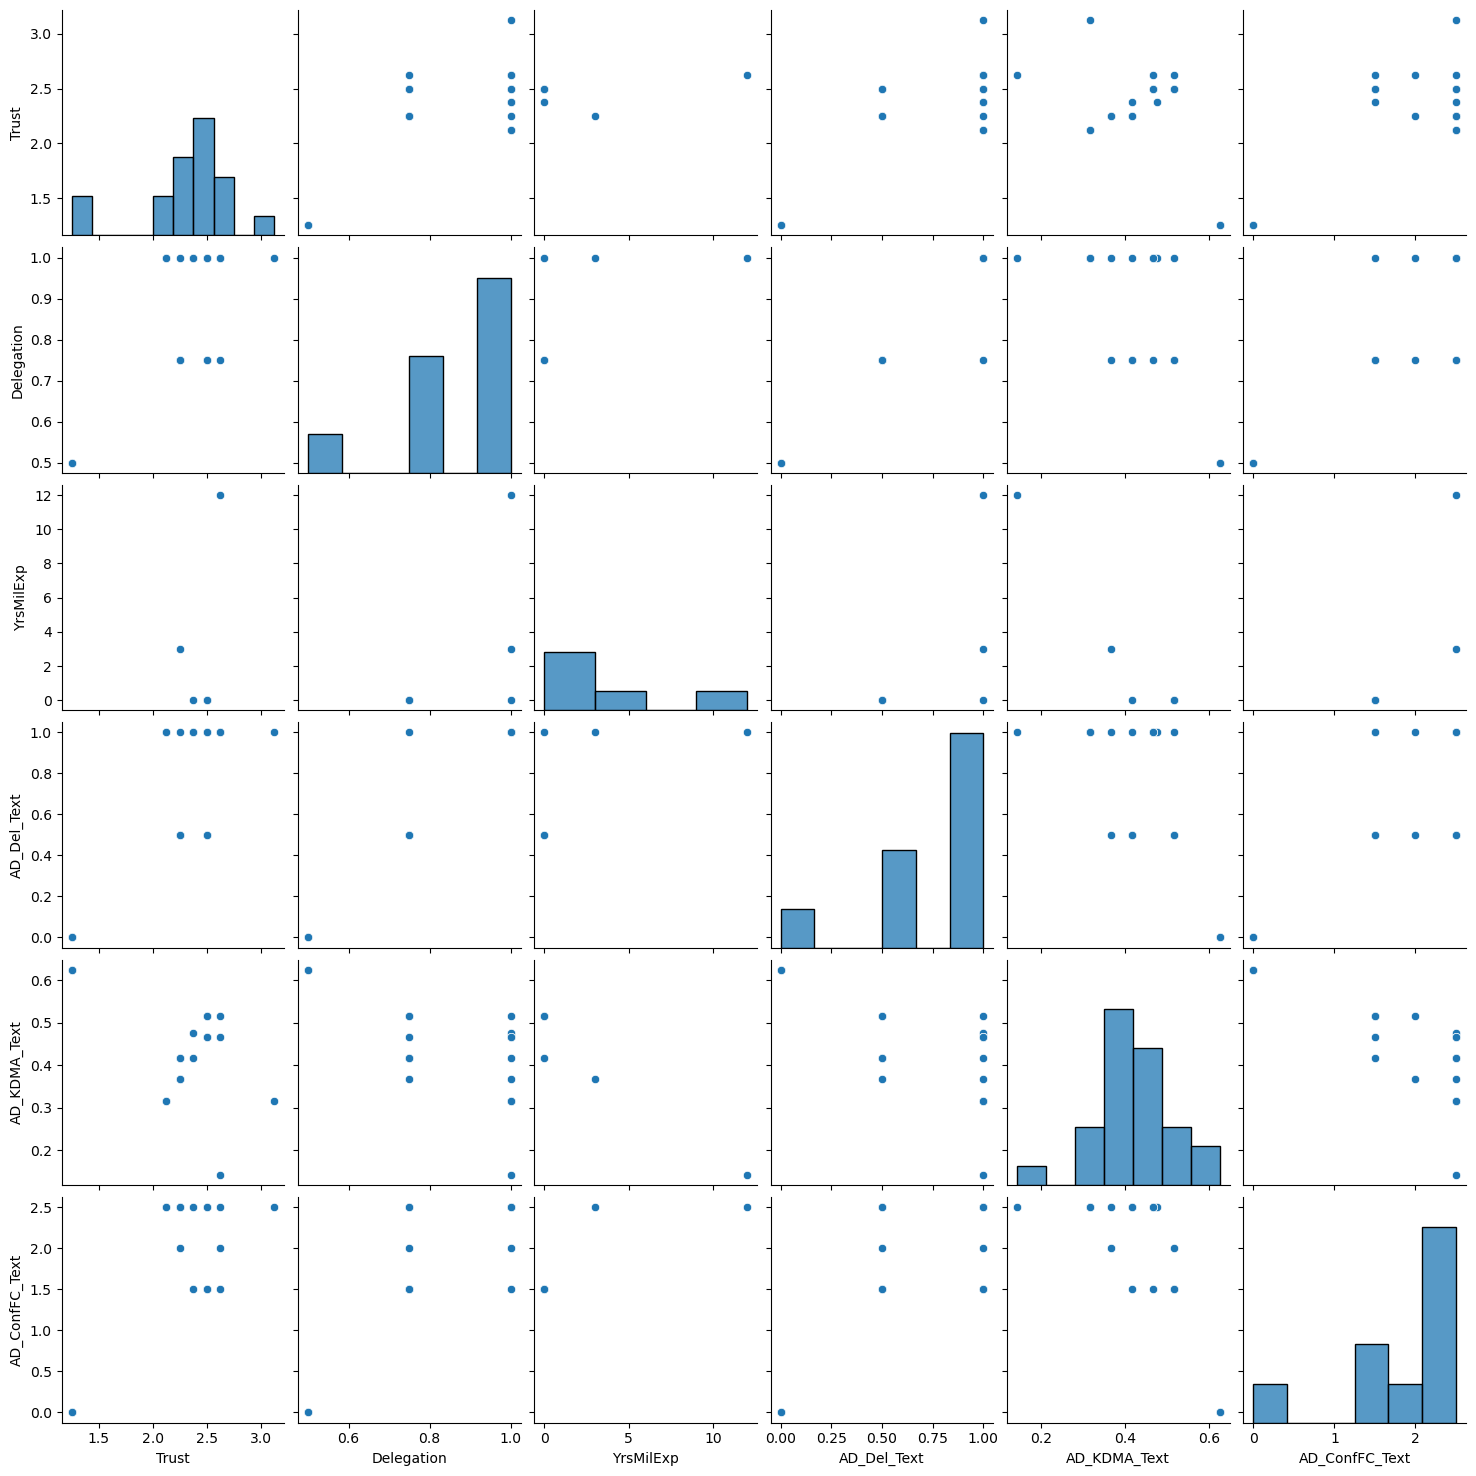

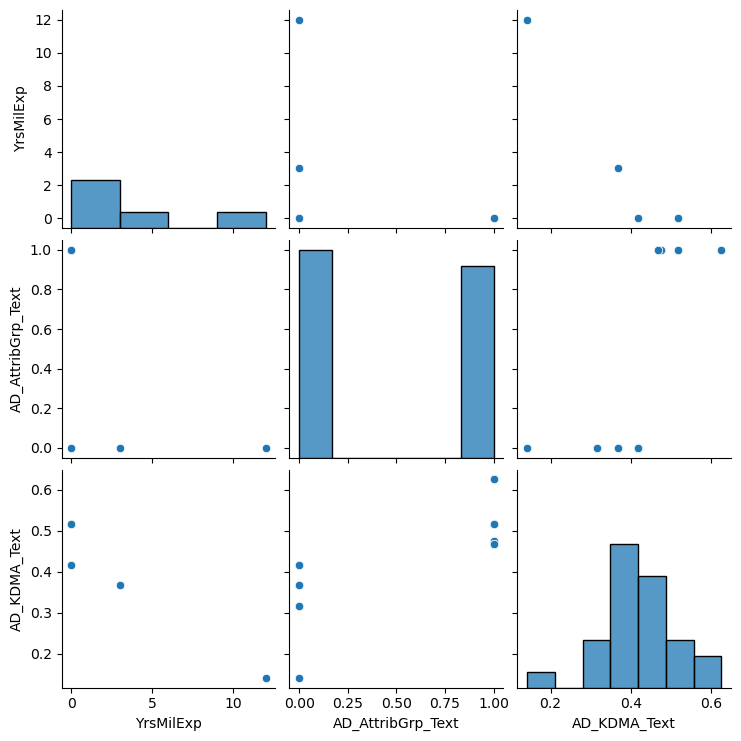

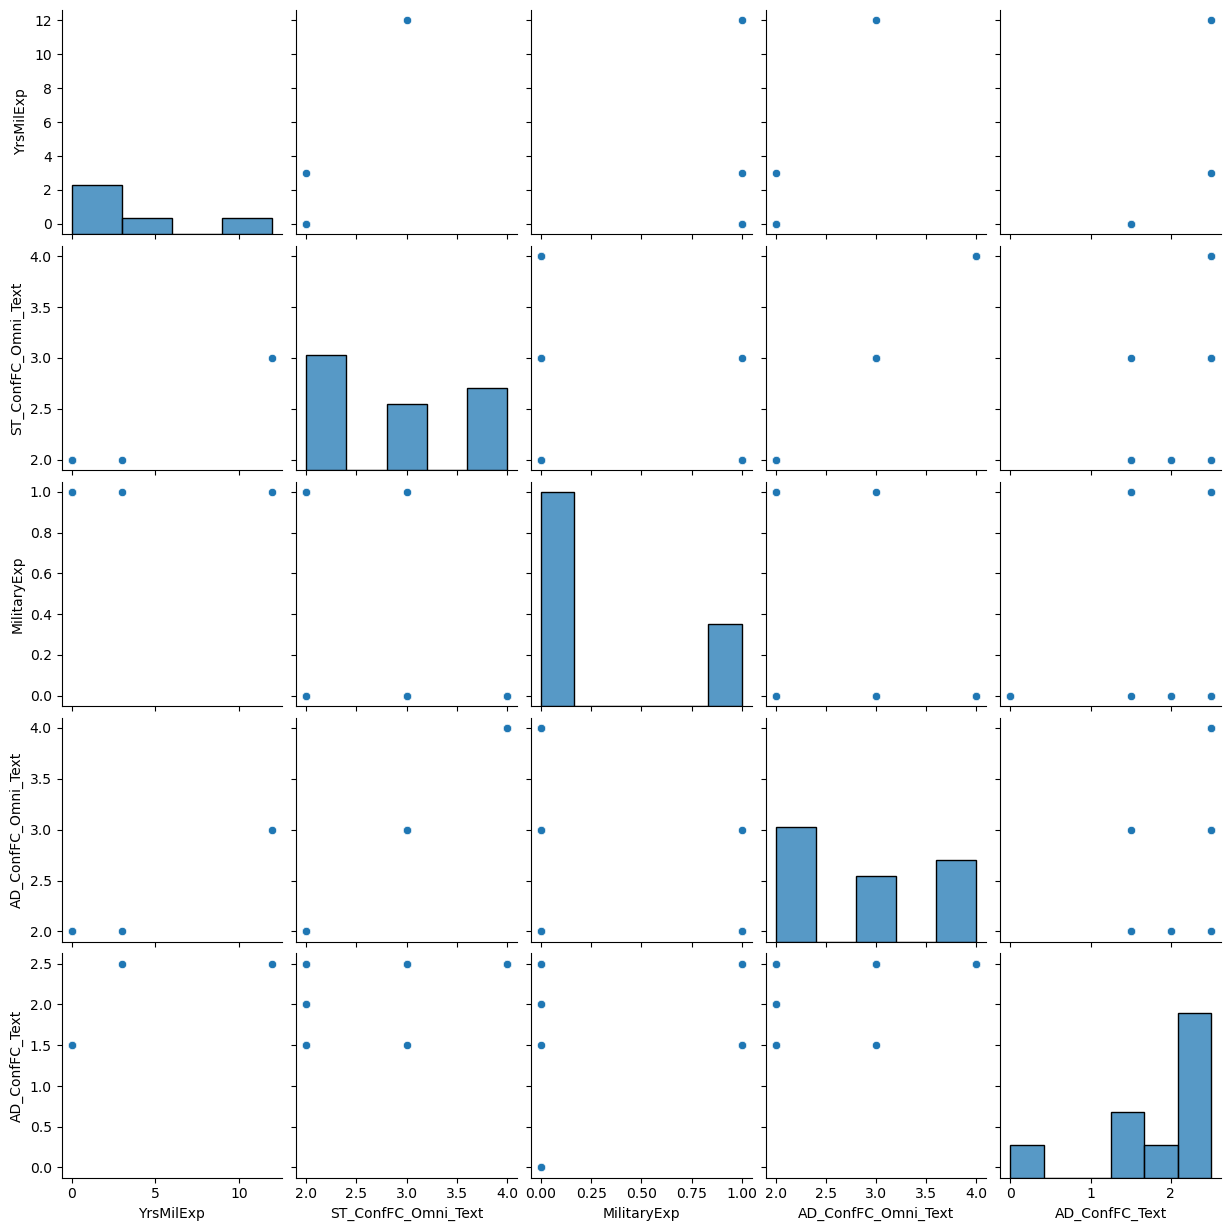

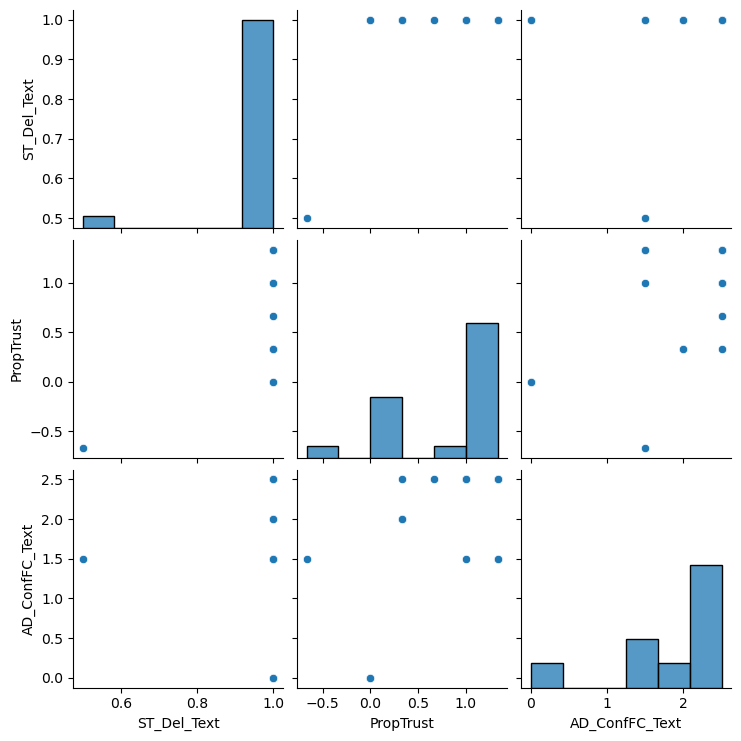

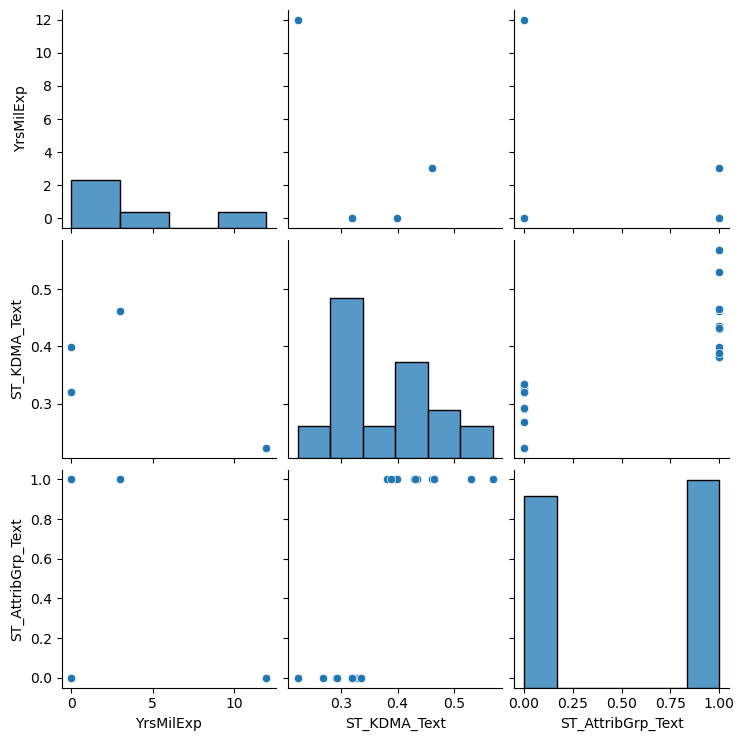

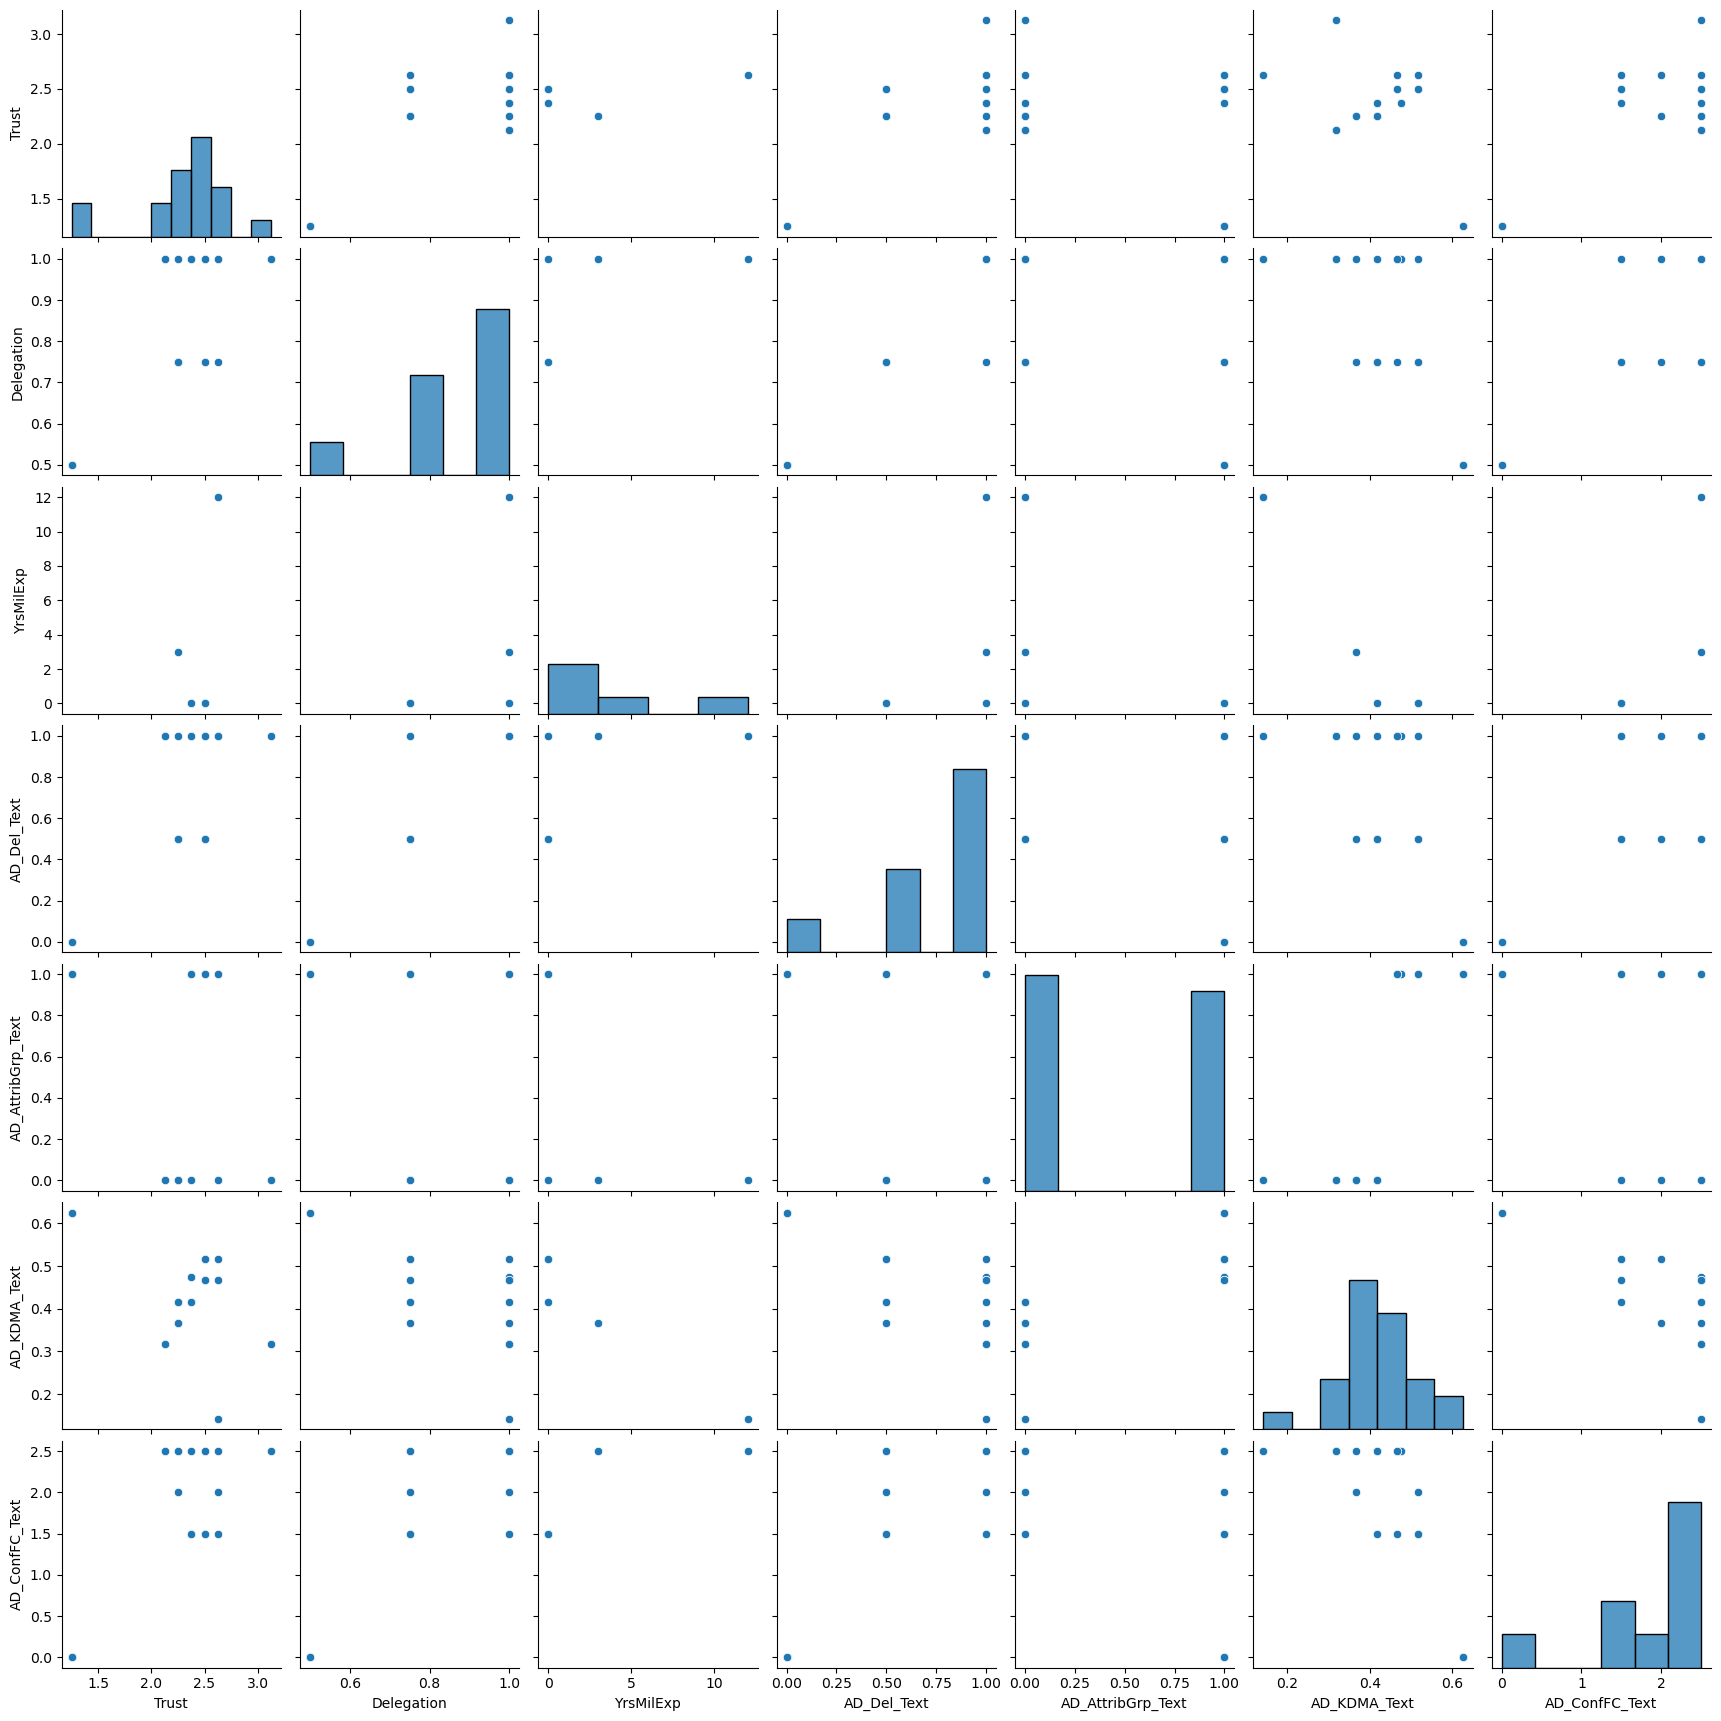

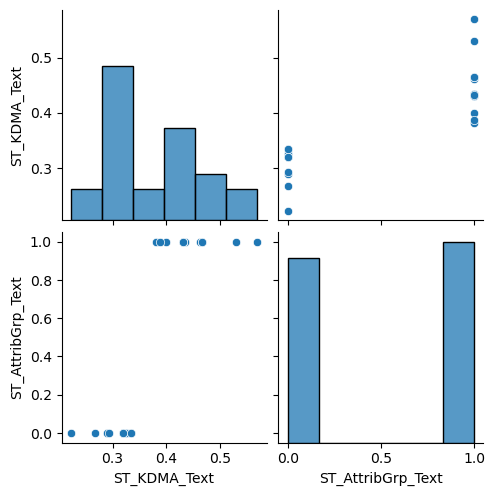

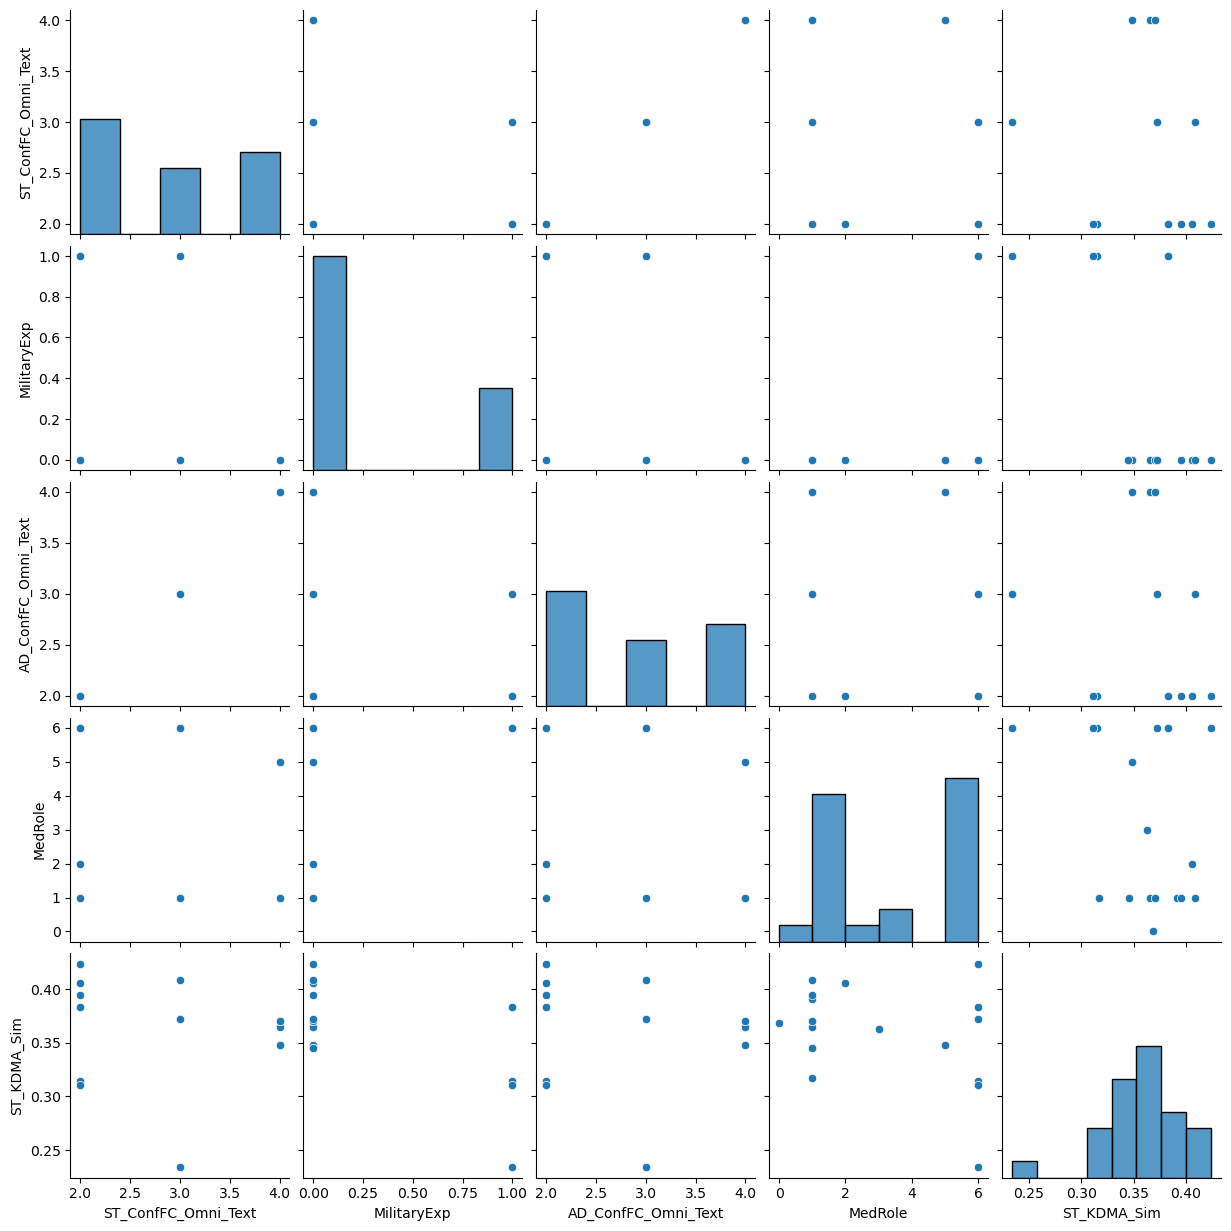

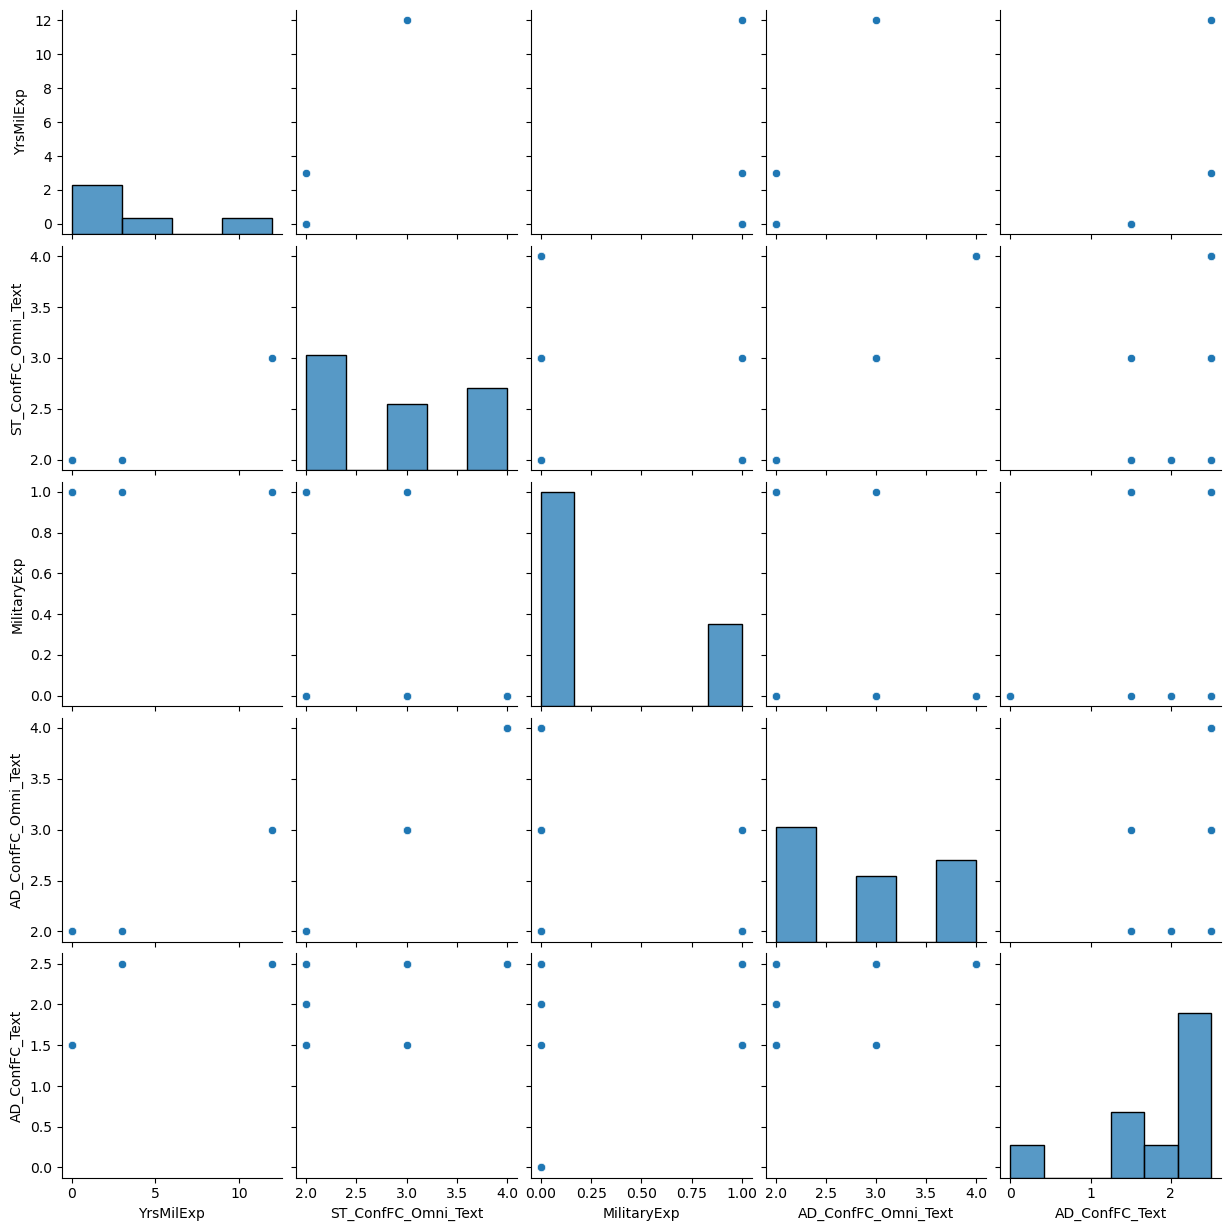

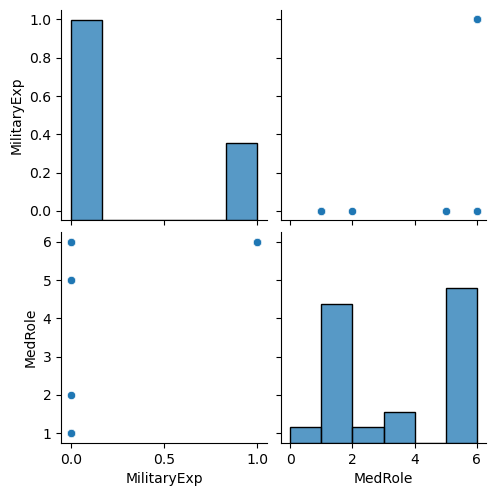

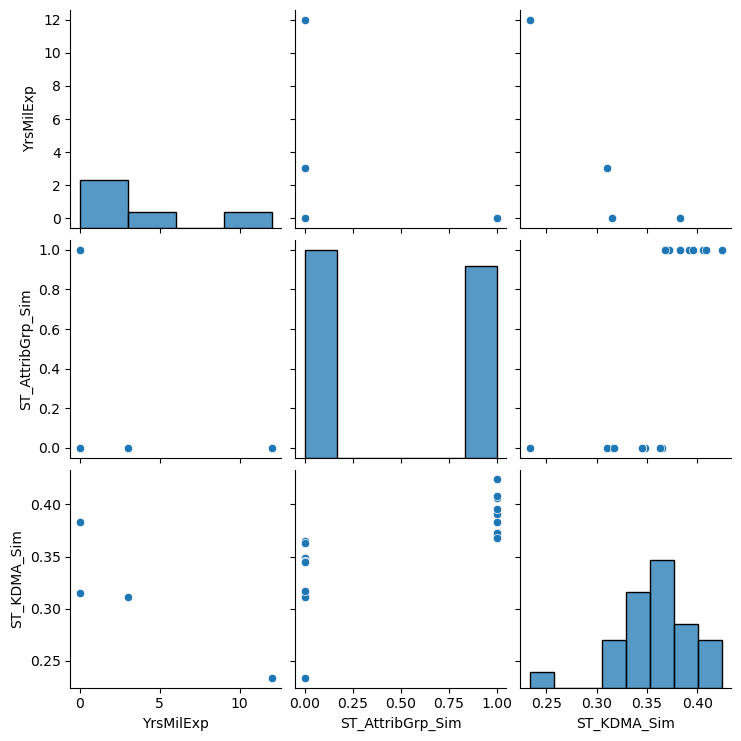

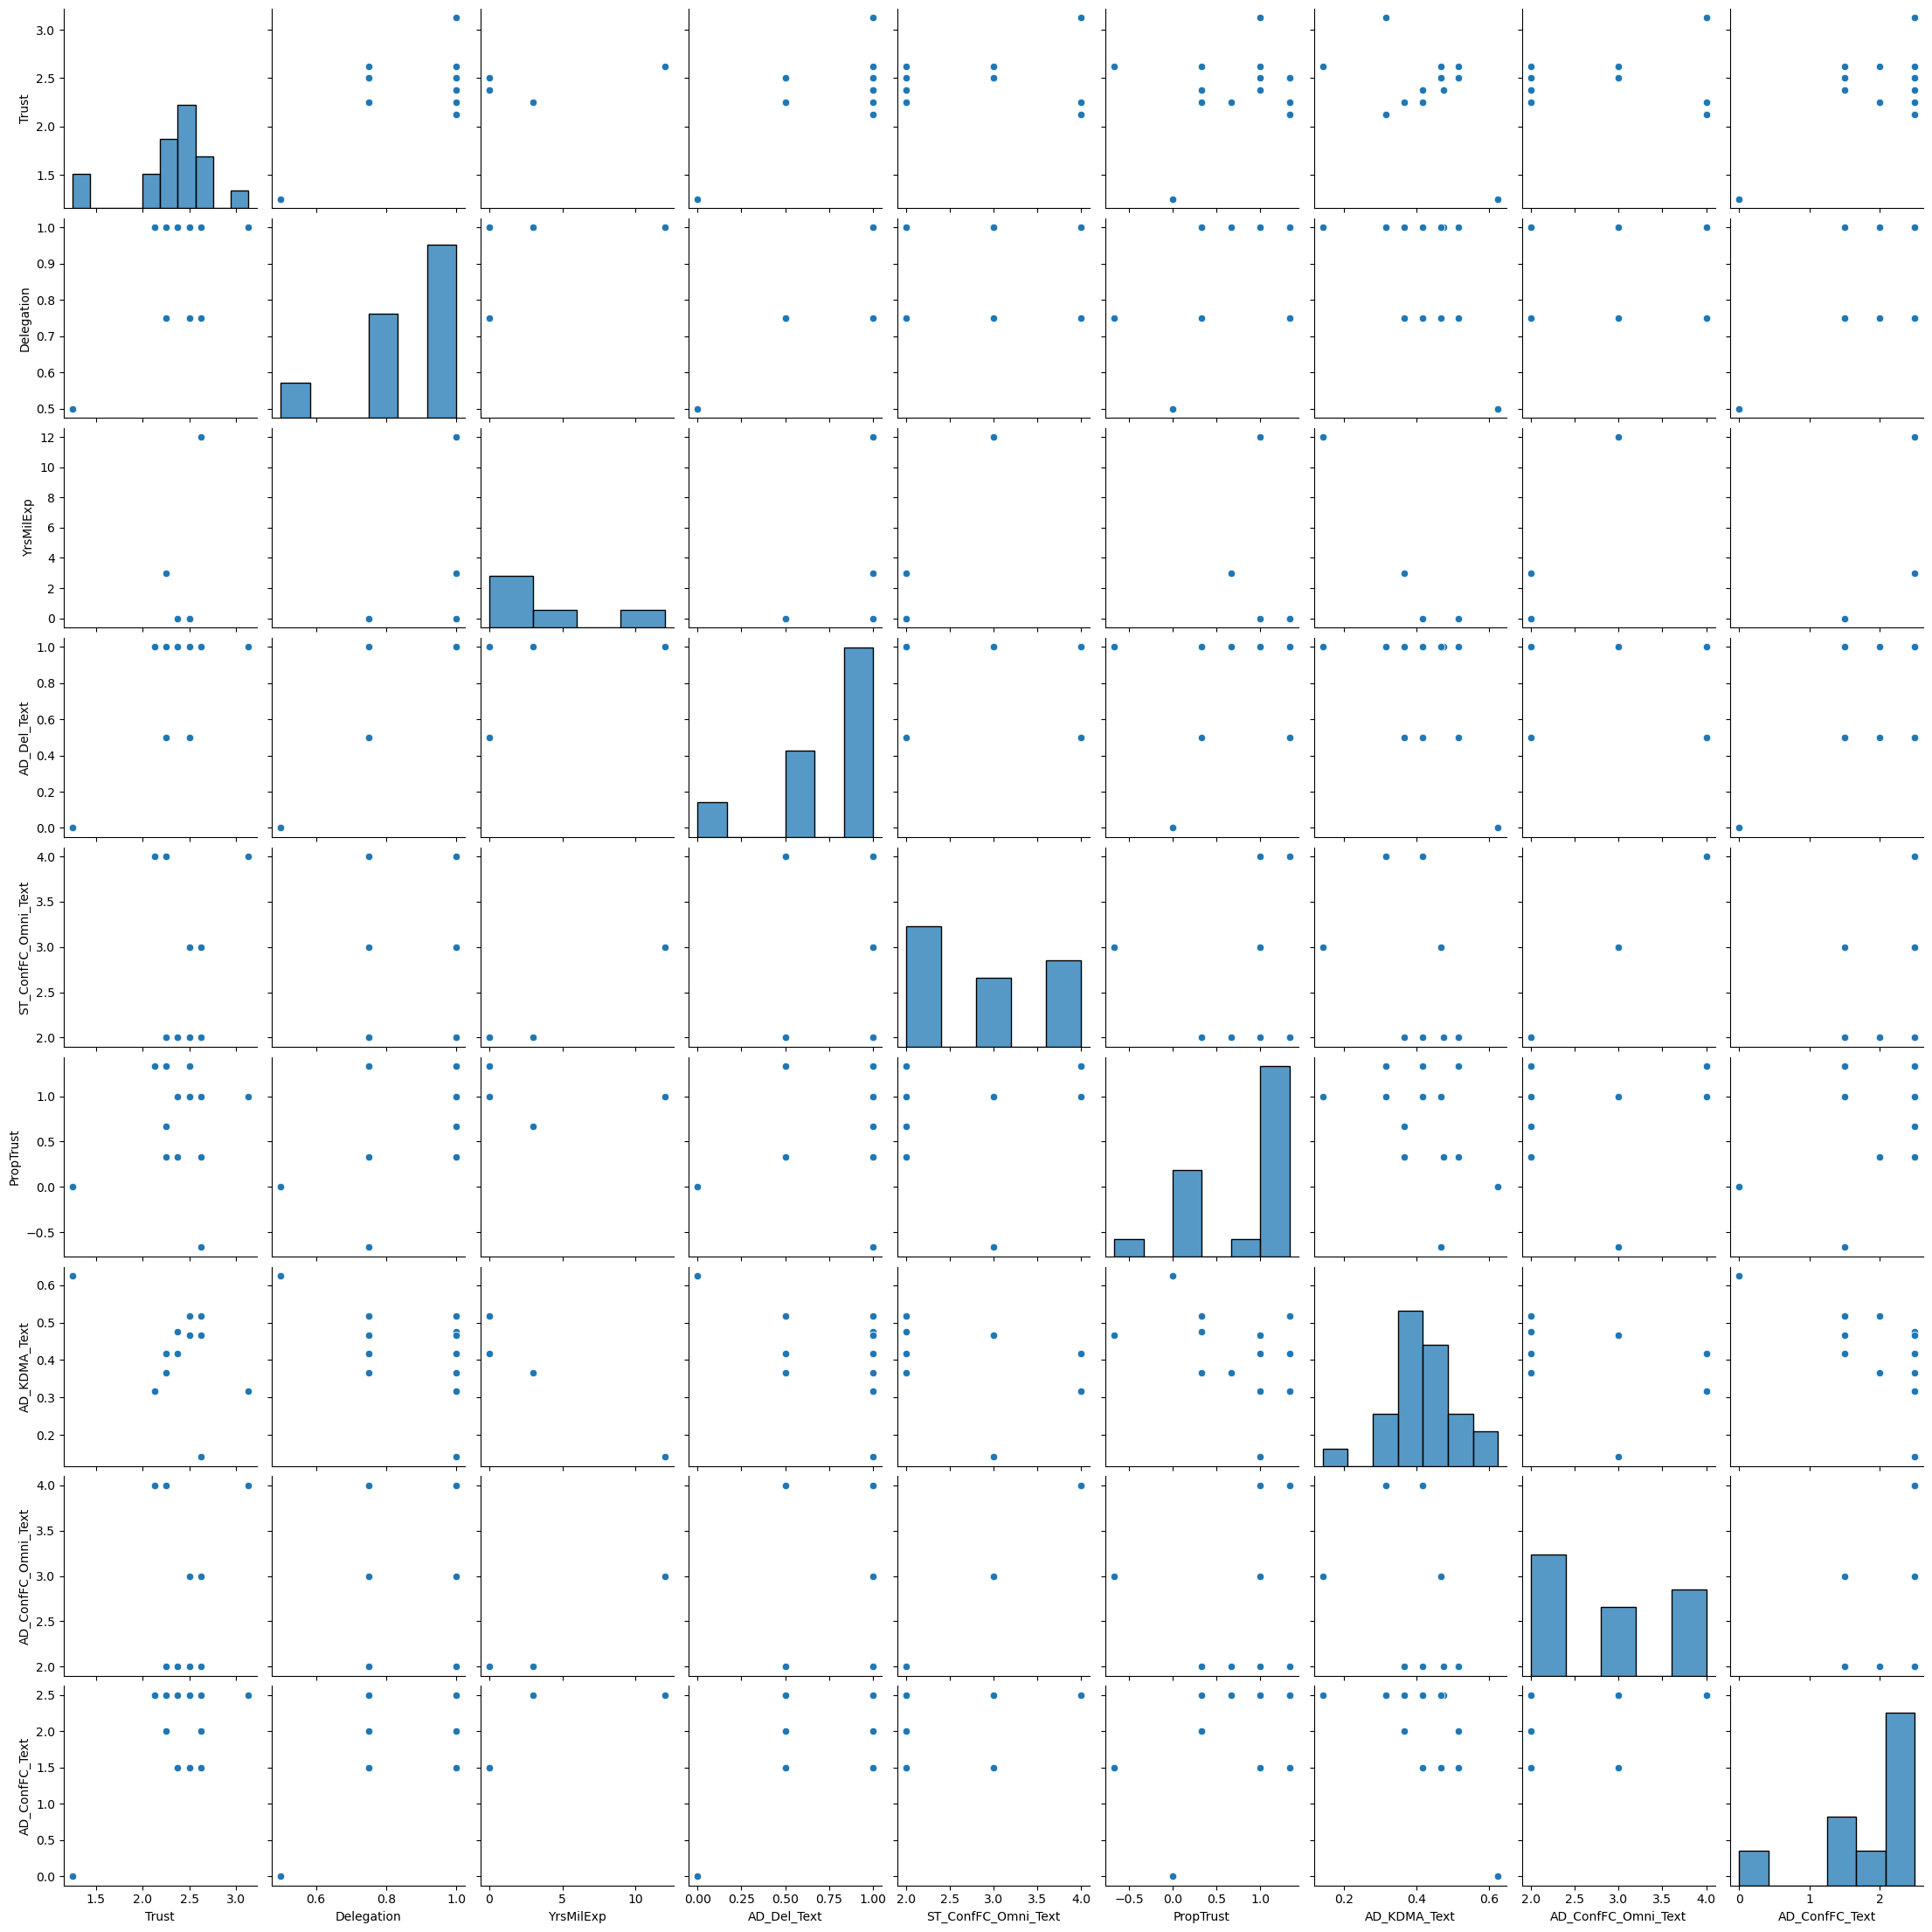

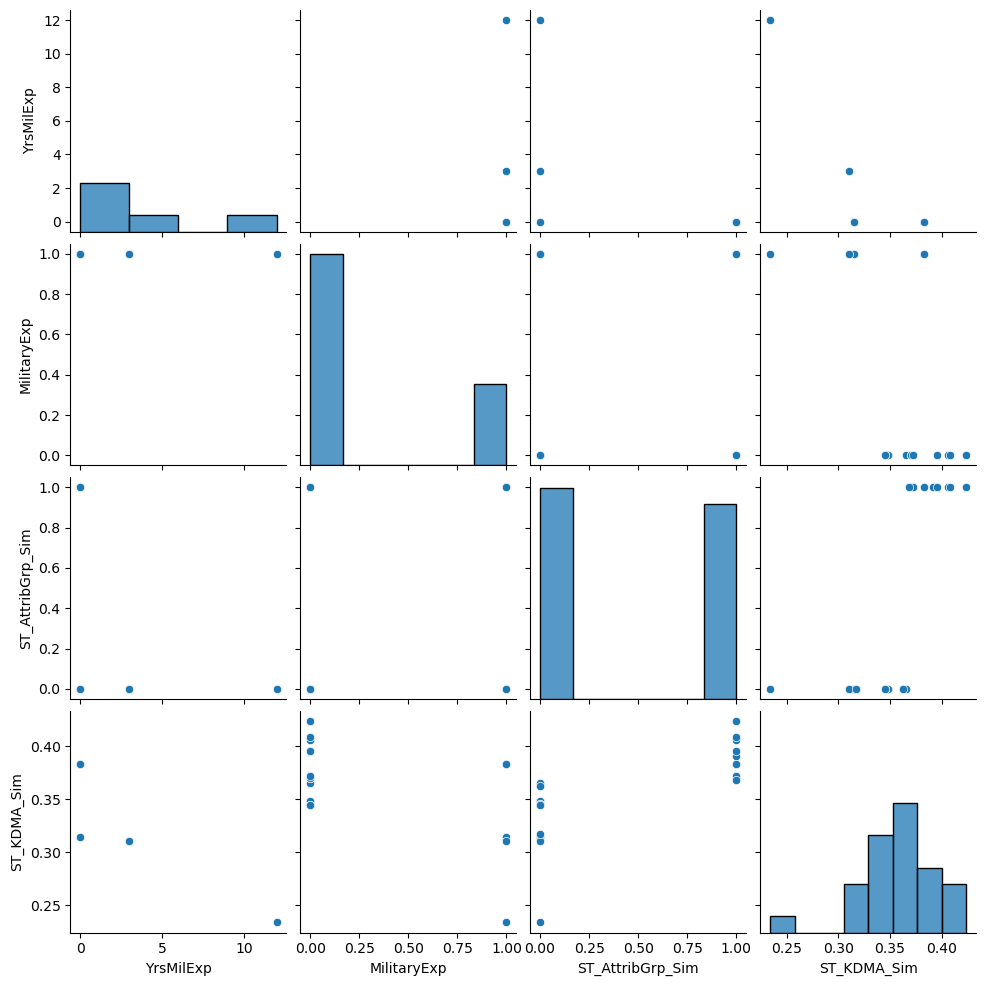

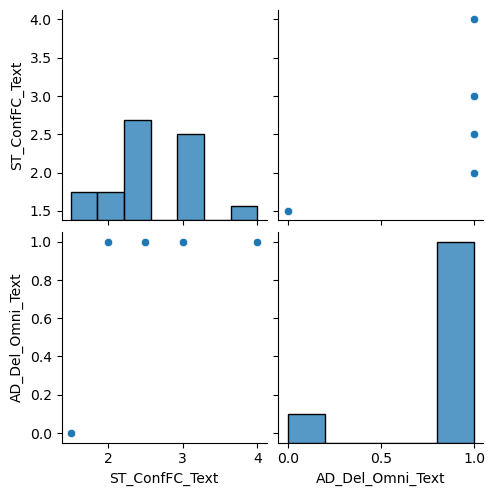

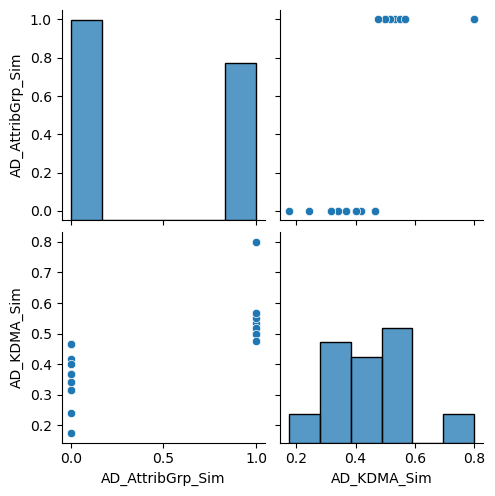

In [16]:

import seaborn as sns

anova_df = DataFrame(anova_rows_list)
column_descriptions_df = nu.get_column_descriptions(anova_df)
mask_series = column_descriptions_df.dtype.isin(['float64', 'int64'])
columns_set = set(column_descriptions_df[mask_series].column_name).difference(set(['scene_id', 'const']))
df = anova_df[participant_columns].corr()
mask_series = df.applymap(lambda x: abs(x) > 0.5)
for cn in df[mask_series].columns:
    columns_list = df[mask_series][cn].dropna().index.tolist()
    if len(columns_list) > 1: PairGrid_obj = sns.pairplot(anova_df[columns_list])

In [17]:

# Which factors contribute to the variance in these outcomes?
# Set up a regression equation (it will be continuous between 0 and 1) as the outcome
from scipy.stats import f_oneway, ttest_ind
import itertools
from scipy.stats import kruskal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm

# Get the numeric columns
column_descriptions_df = nu.get_column_descriptions(anova_df)
mask_series = column_descriptions_df.dtype.isin(['float64', 'int64'])
columns_set = set(column_descriptions_df[mask_series].column_name).difference(set(['scene_id']))

for groupby_column in columns_set:
    
    # Encode the group-by column into dummy variables
    dummy_groupby = pd.get_dummies(anova_df[groupby_column], prefix=groupby_column)
    
    # Concatenate the dummy variables with the dataframe
    anova_with_dummies_df = pd.concat([anova_df, dummy_groupby], axis=1)
    
    # Add a constant term to the independent variables
    anova_with_dummies_df['const'] = 1
    
    # Group data by groupby columns
    grouped_data = anova_with_dummies_df.groupby(groupby_column)
    
    for cn in set(columns_set).difference(set([groupby_column])):
        statements_list = []; display_box_and_whiskers = False; display_qq_plot = False; display_regression_equation = False
        cn_data = anova_with_dummies_df[cn]
        xname = ' '.join([w.title() for w in cn.split('_')])
        statements_list.append(f"\n{xname}{description_dict.get(cn, '')} grouped by {groupby_column}{description_dict.get(groupby_column, '')}")

        # Perform a test for normality
        try:
            from scipy.stats import shapiro_wilk
            
            # Perform Shapiro-Wilk test
            stat, p_value = shapiro_wilk(cn_data)
            
            # Append the test results
            if not pd.isna(stat): statements_list.append(f'Shapiro-Wilk Test for normality ({cn}): Statistic: {stat:.4f}, p-value: {p_value:.4f}')
    
        except:
            from scipy.stats import shapiro
            
            # Perform Shapiro-Francia test
            stat, p_value = shapiro(cn_data)
            
            # Append the test results
            if not pd.isna(stat): statements_list.append(f'Shapiro-Francia Test for normality ({cn}): Statistic: {stat:.4f}, p-value: {p_value:.4f}')

        if grouped_data.ngroups > 1:
            
            # Fail to reject the null hypothesis of normality
            if (p_value >= 0.05):
                
                # Perform ANOVA on values to get F statistic and p-value
                f_statistic, p_value = f_oneway(*[group[cn] for name, group in grouped_data])
                
                # Append the results
                if not pd.isna(p_value): statements_list.append(f"One-way ANOVA for {cn}: F statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")
        
                # Calculate the sum of squares between groups (SS_between)
                mean_overall = cn_data.mean()  # Mean of all values
                SS_between = sum(len(group) * (group[cn].mean() - mean_overall)**2 for name, group in grouped_data)
                
                # Calculate the total sum of squares (SS_total)
                SS_total = sum((value - mean_overall)**2 for name, group in grouped_data for value in group[cn])
                
                # Compute eta-squared (η²) and append the results
                try: eta_squared = SS_between / SS_total
                except: eta_squared = np.nan
                if not pd.isna(eta_squared): statements_list.append(f"    η² (effect size) = {eta_squared:.4f}")
                
                # Generate theoretical quantiles from a standard normal distribution
                theoretical_quantiles = norm.ppf(cn_data.rank() / (len(cn_data) + 1))
    
                display_qq_plot = True
    
            # The data does not come from a normal distribution: consider non-parametric tests
            else:
                
                # Perform Kruskal-Wallis test on values
                kruskal_statistic, p_value = kruskal(*[group[cn] for name, group in grouped_data])
                
                # Access additional test details from the result object
                kruskal_results = kruskal(*[group[cn] for name, group in grouped_data])
                
                # Extract chi-squared statistic (equivalent to H statistic)
                chi_squared = kruskal_results.statistic
                
                # Degrees of freedom (number of groups - 1)
                degrees_of_freedom = len(anova_with_dummies_df[groupby_column].unique()) - 1
                
                # Append the complete results
                statements_list.append(f"Kruskal-Wallis test for {cn}: H statistic = {kruskal_statistic:.4f}, p-value = {p_value:.4f}")
                statements_list.append(f"    χ² = {chi_squared:.4f}, df = {degrees_of_freedom}, p-value = {p_value:.4f}")
                
                # Epsilon squared (effect size)
                n = len(anova_with_dummies_df)  # Total number of observations
                k = len(anova_with_dummies_df[groupby_column].unique())  # Number of groups
            
                # Calculate manually
                try:
                    ss_between = kruskal_results.statistic * n / (k * (k - 1))
                    ss_total = kruskal_results.ss  # Access total sum of squares from results
                    epsilon_squared = ss_between / ss_total
                
                # Alternative way to calculate sum of squares within groups (SSwithin)
                except:
                    data_by_env = grouped_data
                    ss_within = sum([group[cn].var(ddof=0) * len(group) for name, group in data_by_env])
                    
                    # Total sum of squares (SStotal) - using variance of entire data
                    ss_total = cn_data.var(ddof=0) * len(anova_with_dummies_df)
                    
                    # Epsilon squared calculation
                    epsilon_squared = (kruskal_results.statistic * n) / (k * (k - 1) * ss_within / ss_total)
    
                # Append the results
                if not pd.isna(epsilon_squared): statements_list.append(f"    ε² (effect size) = {epsilon_squared:.4f}")
            
            # Test shows a significant difference (p-value < 0.05)
            if p_value < 0.05:
                
                # Compare the pairs
                mask_series = ~anova_with_dummies_df[groupby_column].isnull()
                for pair in itertools.combinations(anova_with_dummies_df[mask_series][groupby_column].unique(), 2):
                    env1 = pair[0]; env2 = pair[1]
                    env1_data = grouped_data.get_group(env1)[cn]
                    env2_data = grouped_data.get_group(env2)[cn]
                    t_statistic, p_value = ttest_ind(env1_data, env2_data)
                    if p_value < 0.05: statements_list.append(f"    t-test between {env1} and {env2}: t = {t_statistic:.4f}, p = {p_value:.4f}")
                
                # Display a box and whiskers plot
                mask_series = ~cn_data.isnull()
                if mask_series.any():
                    transformable_df = anova_with_dummies_df[mask_series]
                    display_box_and_whiskers = True
        
        # Perform linear regression
        columns_list = [cn for cn in anova_with_dummies_df.columns if cn.startswith(f'{groupby_column}_')]
        model = sm.OLS(
            cn_data, anova_with_dummies_df[['const'] + columns_list]
        )
        results = model.fit()
        
        # Append the regression equation
        if not pd.isna(results.params['const']):
            display_regression_equation = True
            statements_list.append("Regression Equation:")
            format_str = "{} = {:.4f} + " + ' + '.join([f'{{:.4f}} * {cn}' for cn in columns_list])
            mask_series = (dataset_organization_df.Variable == groupby_column.replace('_Text', ''))
            if mask_series.any():
                equation_dict = {}
                for kv in dataset_organization_df[mask_series].Labels:
                    kv_split = re.split(' *= *', kv, 0)
                    if len(kv_split) == 2: equation_dict[float(kv_split[0])] = re.sub('[^A-Za-z0-9]+', '_', kv_split[1]).strip('_')
                for k, v in equation_dict.items(): format_str = format_str.replace('_' + str(k), '_' + v)
            statements_list.append(format_str.format(
                cn, results.params['const'], *[results.params[cn] for cn in columns_list]
            ))
        
        if display_regression_equation and (cn in participant_columns):
            print('\n'.join(statements_list))
            if display_qq_plot:
                
                # Create a figure and subplots with 1 row and 2 columns
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
                
                # Create the QQ Plot
                ax1.scatter(theoretical_quantiles, cn_data)
                ax1.set_xlabel('Standard Normal Quantiles')
                ax1.set_ylabel(f'{xname} Values')
                ax1.set_title(f'QQ Plot of {xname}')
                ax1.grid(True)
                
                # Create the Histogram
                ax2 = nu.plot_histogram(
                    anova_with_dummies_df, cn, xname, f'{xname} Histogram', xtick_text_fn=None, ylabel=None, xticks_are_temporal=False, ax=ax2,
                    color=None, bins=100
                )
                
                # Humanize y tick labels
                yticklabels_list = []
                for text_obj in ax2.get_yticklabels():
                    position_tuple = text_obj.get_position()
                    text_obj.set_text(int(position_tuple[1]))
                    yticklabels_list.append(text_obj)
                if (len(yticklabels_list) > 17): ax2.set_yticklabels(yticklabels_list, rotation=90)
                else: ax2.set_yticklabels(yticklabels_list)
                
                # Adjust layout (optional)
                plt.tight_layout()
                
                # Display the plot
                plt.show()
            
            if display_box_and_whiskers:
                fu.plot_grouped_box_and_whiskers(
                    transformable_df,
                    groupby_column,
                    cn,
                    groupby_column,
                    ' '.join([w.title() for w in cn.split('_')]),
                    transformer_name=None,
                    is_y_temporal=False,
                )


Generate a csv file with the following variables for each participant, with one variable (one for each environment) per column and one participant per row:
 1. Count of teleports (TeleportCount_sub; TeleportCount_jungle; TeleportCount_desert; TeleportCount_urban)
 2. Count of voice captures
 3. Count of treatment applied (can you remove the pulse oximeter from this count?)
 4. Count of pulse oximeter use
 5. Total distance covered in the scene
 6. Average time between engage patient and either teleport or engage next patient
 7. Average time per patient (by using any actions that take a patient as a property like gaze and treat and engage)
 8. Count of applied_tag
 9. Apply_tag (expectant) 1 or 0
 10. Count of pulse taken

In [18]:

# Examine the participant ID columns
columns_list = [cn for cn in file_stats_df.columns if 'partici' in cn.lower()]
print(columns_list)
df = file_stats_df[columns_list].drop_duplicates()
print(df.shape)
print(df.participantId.unique().tolist())
print(df.ParticipantID.unique().tolist())
column_descriptions_df = nu.get_column_descriptions(df)
column_descriptions_df

['participantId', 'ParticipantID']
(29, 2)
['2024211', '2024207', nan, '2024225', '2024208', '2024226', '2024217', '2024219', '2024202', '2024201', '2024220', '2024212', '2024218', '2024215', '2024206', '2024203', '2024222', '2024221', '2024223', '2024204', '2024227', '2024224', '2024209', '2024216', '2024214', '2024205']
[2024211.0, 2024208.0, nan, 2024205.0, 2024219.0, 2024214.0, 2024201.0, 2024202.0, 2024217.0, 2024212.0, 2024220.0, 2024209.0, 2024216.0, 2024207.0, 2024204.0, 2024222.0, 2024221.0, 2024223.0, 2024203.0, 2024218.0, 2024215.0, 2024206.0, 2024213.0]


,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,ParticipantID,float64,5,23,0,True,2024201.0,2024223.0,False
1,participantId,object,4,26,0,False,2024201,2024227,False


In [19]:

# Examine the correspondance between the columns
df.sort_values(['participantId', 'ParticipantID'])

,participantId,ParticipantID
11,2024201,2024202.0
10,2024202,2024201.0
19,2024203,2024204.0
32,2024204,2024203.0
57,2024205,2024206.0
18,2024206,2024207.0
1,2024207,2024208.0
5,2024208,2024205.0
48,2024209,2024209.0
0,2024211,2024211.0


In [20]:

# Show any differences between the columns
def is_numeric(value):
    try:
        float(value)
        return not pd.isna(value)
    except ValueError: pass
    try:
        int(value)
        return True
    except ValueError: return False

id_set = set(
    [int(el) for el in df.participantId.unique() if is_numeric(el)]
).symmetric_difference(set(
    [int(el) for el in df.ParticipantID.unique() if is_numeric(el)]
))
mask_series = df.participantId.map(lambda x: is_numeric(x))
if mask_series.any():
    df2 = df[mask_series]
    mask_series = df2.participantId.map(lambda x: int(x) in id_set)
    if mask_series.any(): display(df2[mask_series])
mask_series = df.ParticipantID.map(lambda x: is_numeric(x))
if mask_series.any():
    df2 = df[mask_series]
    mask_series = df2.ParticipantID.map(lambda x: int(x) in id_set)
    if mask_series.any(): display(df2[mask_series])

,participantId,ParticipantID
3,2024225,NaN
6,2024226,NaN
33,2024227,NaN
36,2024224,NaN


,participantId,ParticipantID
58,NaN,2024213.0


In [21]:

# Group by sim 1 and 2
from math import sqrt

groupby_columns = fu.scene_groupby_columns + ['encounter_layout']
rows_list = []
for (session_uuid, scene_id, environment_id), scene_df in elevens_df.groupby(groupby_columns, dropna=False):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns + ['environment_id']}
    row_dict['participant_id1'] = scene_df.participantId.squeeze()
    row_dict['participant_id2'] = scene_df.ParticipantID.squeeze()
    row_dict['sim_id1'] = scene_df.Sim1.squeeze()
    row_dict['sim_id2'] = scene_df.Sim2.squeeze()
    
    for cn in participant_columns:
        cv = scene_df[cn].mode().squeeze()
        if not isinstance(cv, pd.Series): row_dict[cn] = cv

    # Count of teleports (TeleportCount_sub; TeleportCount_jungle; TeleportCount_desert; TeleportCount_urban)
    row_dict['teleport_count'] = fu.get_teleport_count(scene_df)
    
    # Count of voice captures
    row_dict['voice_capture_count'] = fu.get_voice_capture_count(scene_df)

    # Total distance covered in the scene
    total_distance_covered = np.nan
    mask_series = (scene_df.action_type == 'PLAYER_LOCATION') & ~scene_df.location_id.isnull()
    if mask_series.any():
        location_order = [eval(location_id) for location_id in scene_df[mask_series].sort_values('action_tick').location_id]
        total_distance_covered = sum([
            sqrt(
                (first_tuple[0] - last_tuple[0])**2 + (first_tuple[1] - last_tuple[1])**2 + (first_tuple[2] - last_tuple[2])**2
            ) for first_tuple, last_tuple in zip(location_order[:-1], location_order[1:])
        ])
    row_dict['total_distance_covered'] = total_distance_covered
    
    patients_list = eval(f'{environment_id.lower()}_patients_list')
    mask_series = scene_df.patient_id.isin(patients_list)
    participant_df = scene_df[mask_series]

    # Count of treatment applied (can you remove the pulse oximeter from this count?)
    mask_series = participant_df.tool_applied_type.isin([
        'Gauze_Pack', 'Burn_Dressing', 'Gauze_Dressing', 'Pain_Meds', 'Needle', 'Naso', 'IV_Blood', 'SAM_Splint', 'Tourniquet', 'IV_Saline'
    ])
    row_dict['injury_treatments_count'] = participant_df[mask_series].shape[0]

    # Count of pulse oximeter use
    mask_series = participant_df.tool_applied_type.isin(['Pulse_Oximeter'])
    row_dict['pulse_oximeter_count'] = participant_df[mask_series].shape[0]

    # Average time between engage patient and either teleport or engage next patient
    engagement_starts_list = []
    teleport_starts_list = []
    columns_list = ['patient_id', 'action_tick']

    # Get the chronological order of engagement starts for each patient
    for patient_id, patient_df in participant_df.groupby('patient_id'):
        
        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():
            df = patient_df[mask_series].sort_values('action_tick')
            
            # Get the first engagement start that has a location
            mask_series = ~df.location_id.isnull()
            if mask_series.any(): engagement_start = df[mask_series].iloc[0].action_tick
            else: engagement_start = df.iloc[0].action_tick
            
            # Add engagement information to the list
            engagement_tuple = (patient_id, engagement_start)
            engagement_starts_list.append(engagement_tuple)
    
    # Sort the starts list chronologically
    if engagement_starts_list:
        engagement_starts_df = DataFrame(sorted(engagement_starts_list, key=lambda x: x[1], reverse=False), columns=columns_list)

    # Get the teleport starts
    mask_series = ~participant_df.teleport_location.isnull()
    if mask_series.any(): teleport_starts_list = [('teleport', action_tick) for action_tick in participant_df[mask_series].action_tick]
    
    # Sort the starts list chronologically
    if teleport_starts_list:
        teleport_starts_df = DataFrame(sorted(teleport_starts_list, key=lambda x: x[1], reverse=False), columns=columns_list)
    
    # Merge the two data frames together
    if engagement_starts_list and teleport_starts_list:
        df = pd.concat([engagement_starts_df, teleport_starts_df], axis='index').sort_values('action_tick').reset_index(drop=True)
        
        # Remove all but the last sequential teleport
        previous_teleport = False
        last_patient = ''
        last_index = -1
        drop_list = []
        for row_index, patient_id in df.patient_id.iteritems():
            if all(map(lambda x: x == 'teleport', [last_patient, patient_id])): previous_teleport = True
            if previous_teleport: drop_list.append(last_index)
            previous_teleport = False
            last_patient = patient_id
            last_index = row_index
        df = df.drop(index=drop_list)
    
    elif engagement_starts_list: df = engagement_starts_df
    elif teleport_starts_list: df = teleport_starts_df
    event_order = df.sort_values('action_tick').action_tick.tolist()
    average_time_elapsed = np.mean(np.array([
        abs(first_event - last_event) for first_event, last_event in zip(event_order[:-1], event_order[1:])
    ]))
    row_dict['average_time_between_engagement_or_teleportation'] = average_time_elapsed

    # Average time per patient (by using any actions that take a patient as a property like gaze and treat and engage)
    gaze_starts_list = []

    # Get the gaze starts
    mask_series = ~participant_df.player_gaze_location.isnull()
    if mask_series.any(): gaze_starts_list = [(patient_id, action_tick) for (patient_id, action_tick), _ in participant_df[mask_series].groupby(
        ['patient_id', 'action_tick']
    )]
    
    # Sort the starts list chronologically
    if gaze_starts_list:
        gaze_starts_df = DataFrame(sorted(gaze_starts_list, key=lambda x: x[1], reverse=False), columns=columns_list)
    
    # Merge the two data frames together
    if engagement_starts_list and gaze_starts_list:
        df = pd.concat([engagement_starts_df, gaze_starts_df], axis='index').sort_values('action_tick').reset_index(drop=True)
        
        # Remove all but the last consecutive patient ID
        previous_gaze = False
        previous_patient = ''
        previous_index = -1
        drop_list = []
        for row_index, patient_id in df.patient_id.iteritems():
            if previous_patient == patient_id: previous_gaze = True
            if previous_gaze: drop_list.append(previous_index)
            previous_gaze = False
            previous_patient = patient_id
            previous_index = row_index
        df = df.drop(index=drop_list)
    
    elif engagement_starts_list: df = engagement_starts_df
    event_order = df.sort_values('action_tick').action_tick.tolist()
    average_time_elapsed = sum([
        abs(first_event - last_event) for first_event, last_event in zip(event_order[:-1], event_order[1:])
    ]) / fu.get_patient_count(participant_df)
    row_dict['average_time_per_patient'] = average_time_elapsed
    
    # Count of applied_tag
    mask_series = participant_df.action_type.isin(['TAG_APPLIED'])
    row_dict['tag_applied_count'] = participant_df[mask_series].shape[0]
    
    # Apply_tag (expectant) 1 or 0
    mask_series = participant_df.patient_salt.isin(['EXPECTANT'])
    patient_ids_list = participant_df[mask_series].patient_id.unique().tolist()
    mask_series = participant_df.patient_id.isin(patient_ids_list)
    tag_values_list = [fu.get_tag_value(patient_df) for _, patient_df in participant_df[mask_series].groupby('patient_id')]
    assert len(tag_values_list) == 1, "You have more than one EXPECTANT patient"
    row_dict['tag_applied_expectant'] = tag_values_list[0]
    
    # Count of pulse taken
    row_dict['pulse_taken_count'] = fu.get_pulse_taken_count(participant_df)

    rows_list.append(row_dict)

In [22]:

df = DataFrame(rows_list)
print(df.shape) # (32, 40)
nu.store_objects(metrics_evaluation_open_world_participants_df=df)
nu.save_data_frames(metrics_evaluation_open_world_participants_df=df)

(31, 40)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_participants_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_participants_df.csv


In [23]:

columns_list = ['environment_id', 'teleport_count']

# Use pivot_table with fill_value for missing entries
pivoted_df = df[columns_list].pivot_table(index=df.index, columns='environment_id', values='teleport_count', fill_value=np.nan)

# Rename columns to remove spaces (optional)
pivoted_df.columns = ['teleport_count_' + col.lower().replace(' ', '_') for col in pivoted_df.columns]

combined_df = pd.concat([df, pivoted_df], axis='columns').reset_index(drop=True)
print(combined_df.shape) # (32, 44)
nu.store_objects(metrics_evaluation_open_world_participants_df=combined_df)
nu.save_data_frames(metrics_evaluation_open_world_participants_df=combined_df)

(31, 44)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_participants_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_participants_df.csv


In [24]:

print(df[columns_list].to_dict(orient='list'))
print(f"""
        from pandas import DataFrame
        
        df = DataFrame({{
            "environment_id": {df.environment_id.tolist()},
            "teleport_count": {df.teleport_count.tolist()}
        }})""")

{'environment_id': ['Submarine', 'Urban', 'Urban', 'Submarine', 'Desert', 'Jungle', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Desert', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Jungle', 'Submarine', 'Desert', 'Desert', 'Desert', 'Submarine', 'Desert', 'Jungle', 'Urban', 'Urban'], 'teleport_count': [62, 30, 87, 109, 6, 27, 17, 33, 75, 35, 80, 114, 71, 32, 82, 63, 134, 16, 46, 26, 33, 39, 53, 48, 74, 38, 77, 55, 65, 68, 126]}

        from pandas import DataFrame
        
        df = DataFrame({
            "environment_id": ['Submarine', 'Urban', 'Urban', 'Submarine', 'Desert', 'Jungle', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Desert', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Jungle', 'Submarine', 'Desert', 'Desert', 'Desert', 'Submarine', 'Desert', 'Jungle', 'Urban', 'Urban'],
            "teleport_count": [62, 30, 87, 109, 6, 27, 17, 33, 75, 35, 80, 114, 71, 32


# Maintenance

In [10]:

# Test an example regression equation
import unittest

suite = unittest.TestSuite()
class RegressionEquationTest(unittest.TestCase):
    def test_is_very_close_to_zero(self):
        result = (anova_df.mean_percent_accurate_tagging - (
            11.5687 +
            5.0980 * anova_df.Environment_Desert +
            3.3303 * anova_df.Environment_Jungle +
            2.0424 * anova_df.Environment_Submarine +
            1.0980 * anova_df.Environment_Urban
        )).sum()
        self.assertAlmostEqual(result, 0, places=2)
suite.addTest(unittest.makeSuite(RegressionEquationTest))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [44]:

# Check for specific inconsistency with the JSON data
mask_series = (elevens_df.configData_scene == 'sim-desert') & (elevens_df.configData_scenarioData_name == 'Jungle')
if mask_series.any(): display(elevens_df[mask_series].dropna(axis='columns', how='all').T)

In [45]:

# Show all sim types
elevens_df.configData_scene.unique().tolist()

['sim-jungle', 'sim-sub', 'sim-desert', 'sim-urban-sanitized', nan]

In [46]:

# Show all sim names
elevens_df.configData_scenarioData_name.unique().tolist()

['Jungle Eval', 'Submarine Eval', 'Desert', 'Urban', nan]

In [47]:

# Show all sim combos
columns_list = ['configData_scene', 'configData_scenarioData_name', 'configData_scenarioData_description']
display(elevens_df[columns_list].drop_duplicates().sort_values(columns_list))
display(elevens_df.groupby(columns_list, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

,configData_scene,configData_scenarioData_name,configData_scenarioData_description
48886,sim-desert,Desert,Desert
1526,sim-jungle,Jungle Eval,Jungle Eval
6451,sim-sub,Submarine Eval,submarine Eval Scenario
60314,sim-urban-sanitized,Urban,Urban Scenario
81568,NaN,NaN,NaN


,,,record_count
configData_scene,configData_scenarioData_name,configData_scenarioData_description,
sim-desert,Desert,Desert,14936
sim-jungle,Jungle Eval,Jungle Eval,20634
sim-sub,Submarine Eval,submarine Eval Scenario,18519
sim-urban-sanitized,Urban,Urban Scenario,16657
NaN,NaN,NaN,9618


In [31]:

# Explicitly display all inconsistencies within the JSON data
print()
columns_list = ['configData_scene', 'configData_scenarioData_name', 'configData_scenarioData_description']
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
for (configData_scene, configData_scenarioData_name, configData_scenarioData_description), environment_df in elevens_df.groupby(columns_list, dropna=False):
    print(); print(configData_scene)
    if configData_scene == 'sim-desert':
        patients_list = desert_patients_list
    elif configData_scene == 'sim-jungle':
        patients_list = jungle_patients_list
    elif configData_scene == 'sim-sub':
        patients_list = submarine_patients_list
    elif configData_scene == 'sim-urban-sanitized':
        patients_list = urban_patients_list
    else:
        patients_list = desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
    mask_series = environment_df.patient_id.isin(patients_list)
    print(environment_df[mask_series].shape)
    for (session_uuid, scene_id), scene_df in environment_df.groupby(fu.scene_groupby_columns):
        print(session_uuid, scene_id)
        for env_str in ['desert', 'jungle', 'submarine', 'urban']:
            patients_list = eval(f'{env_str}_patients_list')
            if all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list)):
                print(f'Has the patients for the {env_str} environment')
    #     for patient_id in patients_list: print(patient_id, patient_id in scene_df.patient_id.unique().tolist())
    gb = environment_df.groupby(fu.scene_groupby_columns).filter(
        lambda scene_df: all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list))
    )
    display(gb.shape)



sim-desert
(173, 114)
6db9446c-2cd4-41b4-be8d-be5ccbbc6e05 0
Has the patients for the desert environment
7e23cc31-422a-42e1-acb5-964c661750f4 0
Has the patients for the desert environment
b5989edc-8348-4b84-b649-87fc4f1cca53 0
Has the patients for the desert environment
bccb0095-5efd-4c5c-ad58-8b8624f9ab56 0
Has the patients for the desert environment
c99de80f-15cc-45cb-aa64-5af0f2f118ca 0
Has the patients for the desert environment


(0, 114)


sim-jungle
(506, 114)
287389c4-4c48-4483-87c0-6b363b57bde2 0
Has the patients for the jungle environment
2e8f6555-a7fa-4b54-8132-c030d697b4ad 0
Has the patients for the jungle environment
3cf14e31-f416-4c78-8a69-91bf0c685448 0
Has the patients for the jungle environment
44484bce-c7cc-41ca-a871-f7b9b2e3c847 0
Has the patients for the jungle environment
4bc46c8c-66e7-463d-b3a1-2a8303af4fd1 0
Has the patients for the jungle environment
5d94f0d4-a1b1-4d18-8a62-591e196006a9 0
Has the patients for the jungle environment
67dc0230-511d-41ac-ae9b-850900ab9e6a 0
Has the patients for the jungle environment
70eef02d-d2d0-458e-a8bb-f6511bf47a0c 0
Has the patients for the jungle environment
8839e3b8-be5e-4878-8aaf-26c656ae2270 0
Has the patients for the jungle environment
d13091cc-98e4-4aba-8d02-7eca8bd1a30c 0
Has the patients for the jungle environment
de6d297c-23d6-4f85-a873-f48e90b01542 0
Has the patients for the jungle environment


(0, 114)


sim-sub
(389, 114)
04f80090-9e61-431d-8473-dccb75fed04d 0
Has the patients for the submarine environment
21f8cb5d-f5ac-4a01-9287-43df5f6751a1 0
Has the patients for the submarine environment
50b15e40-9860-4574-8ab8-0bd960fe27de 0
Has the patients for the submarine environment
a7ce6f7b-6466-4281-9496-92b640d9d04b 0
Has the patients for the submarine environment
c6d3a90f-68c0-4948-bd96-537e80973605 0
Has the patients for the submarine environment
e8b9f065-d449-4dee-98e7-298568054411 0
Has the patients for the submarine environment


(0, 114)


sim-urban-sanitized
(269, 114)
0c0cc880-b3fb-488d-a468-0e67c17ca176 0
Has the patients for the urban environment
0fb9b0c5-21bb-4f2a-b97f-a01a5e67e492 0
Has the patients for the urban environment
12988238-24b6-4ac2-9f33-398321e82ae0 0
Has the patients for the urban environment
1995e7ef-ef02-4fc1-b1ab-f137dbf69d48 0
Has the patients for the urban environment
23081f6e-875e-44f5-8bd0-edc3905f5c2c 1
Has the patients for the desert environment
45365e18-6e38-48e7-b4a2-6b448b209034 0
Has the patients for the urban environment
6666ee6b-863b-49d1-8097-97e6aa4fb39d 0
Has the patients for the urban environment
df2fcf88-874b-4cf9-9707-3fa0b30c348f 0
Has the patients for the urban environment


(16608, 114)


nan
(443, 114)
5d8d73a3-1898-4f64-8676-73edd1b7daa0 0
Has the patients for the jungle environment
dfec642f-45c9-4813-91d8-3445d5ca763c 0
Has the patients for the urban environment


(5656, 114)

In [33]:

# Display a manually created data frame for testing and prompt generation
print('''
        from pandas import DataFrame
        
        anova_df = DataFrame({''')
for k, v in anova_df.to_dict(orient='list').items(): print(f"            '{k}': {v},")
print('''        })''')


        from pandas import DataFrame
        
        anova_df = DataFrame({
            'Environment': ['Desert', 'Desert', 'Desert', 'Desert', 'Desert', 'Desert', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Submarine', 'Submarine', 'Submarine', 'Submarine', 'Submarine', 'Submarine', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban'],
            'session_uuid': ['23081f6e-875e-44f5-8bd0-edc3905f5c2c', '6db9446c-2cd4-41b4-be8d-be5ccbbc6e05', '7e23cc31-422a-42e1-acb5-964c661750f4', 'b5989edc-8348-4b84-b649-87fc4f1cca53', 'bccb0095-5efd-4c5c-ad58-8b8624f9ab56', 'c99de80f-15cc-45cb-aa64-5af0f2f118ca', '287389c4-4c48-4483-87c0-6b363b57bde2', '2e8f6555-a7fa-4b54-8132-c030d697b4ad', '3cf14e31-f416-4c78-8a69-91bf0c685448', '44484bce-c7cc-41ca-a871-f7b9b2e3c847', '4bc46c8c-66e7-463d-b3a1-2a8303af4fd1', '5d8d73a3-1898-4f64-8676-73edd1b7daa0', '5d94f0d4-a1b1-4d18-8a62-591e196006a9', '67dc0230-511d